# **Sentiment Analysis: Amazon Phone Reviews** 

### Problem Description and Solution:
Improve forum environments by automatically rating reviews or comments and therefore filtering and giving feedback to the company.
The rating can vary from standard Sentiment Analysis to a more detailed scale.
Here a domain specific Amazon dataset is used (but can be transferred to other datasets) to predict if a review was good or bad.
The original ratings were transformed to Binary Ratings: 5-3 -> 1, 0-2 -> 0

### Importing relevant Libraries

In [ ]:
# for colab
%pip install symspellpy
%pip install wordcloud
%pip install "tensorflow>=2.0.0"
%pip install -upgrade tensorflow-hub
%pip install catboost
%pip install imblearn

COLAB = True

import pandas as pd
import numpy as np


# plotting

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

# text processing

import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
# spelling correction
import pkg_resources
from symspellpy import SymSpell, Verbosity
from nltk.corpus import wordnet

# modelling
from sklearn import pipeline
from sklearn.utils import class_weight

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.kernel_approximation import Nystroem

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


import tensorflow_hub as hub
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout, Embedding
from keras import layers
from keras import backend as K
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


# file system

import os



# suppress warnings
import warnings
warnings.filterwarnings('ignore')


# downloads

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Loading and Discovering Data

In [ ]:
# List all available files
if not COLAB:
  print(os.listdir("./inputdata/"))

'/content'

In [ ]:
# load data into pandas dataframe
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  data = pd.read_csv("./drive/MyDrive/Amazon_Unlocked_Mobile.csv")
else:
  data = pd.read_csv('./inputdata/Amazon_Unlocked_Mobile.csv')
data.head()


Mounted at /content/drive


Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. The only...           0.0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [ ]:
# print total number of null/nan values and relativ to data size

print(data.isnull().sum())
print((data.isnull().sum() / data.shape[0]) * 100)

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64
Product Name     0.000000
Brand Name      15.747874
Price            1.433646
Rating           0.000000
Reviews          0.014982
Review Votes     2.971197
dtype: float64


Insights:
- reviews: cut out rows with NaN Values, 62 rows probably not relevant
- votes: fill in with value 0

Probably not used to prevent prejudice and focus more on text:

- brand name: fill NaN Values with 'Unknown' value
- price: fill in with 0 or if used: fill in with mean or other method depended on price distribution

In [ ]:
# overall insight in numerical distribution
data.describe()

Price         Rating   Review Votes
count  407907.000000  413840.000000  401544.000000
mean      226.867155       3.819578       1.507237
std       273.006259       1.548216       9.163853
min         1.730000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       144.710000       5.000000       0.000000
75%       269.990000       5.000000       1.000000
max      2598.000000       5.000000     645.000000

Insights:
- price has some outliers: important if we want to fill in NaN Values and use price as a feature
- rating mainly positive: at least 50% 5* reviews
- also avg rating over 3.8

-> later have a look at rating distribution to see if data is unbalanced

In [ ]:
# overall insight in distribution of object columns
data.describe(include=['O'])

Product Name Brand Name Reviews
count                                              413840     348669  413778
unique                                               4410        384  162491
top     Apple iPhone 4s 8GB Unlocked Smartphone w/ 8MP...    Samsung    Good
freq                                                 1451      65747    2879

Insights:
- for using brand: mainly Samsung products, maybe other dominant brands, so that we can cut out or rename minor brands to do one hot encoding or sth. similar


In [ ]:
# get a basic idea how the reviews look like
pd.set_option('display.max_colwidth', 300)
rand = np.random.randint(0, data.shape[0] - 1, 30)
data.iloc[rand]['Reviews']

119443                                                                                                                                                There is an easy way to fix the volume on this phone,dial *#*#3643366#*#,scroll over to audio, change all Max volume settings to 160. They are 124 set factory.
86735                                                                                                                                                                                                  BlackBerry makes a solid product this product was another in their lineup. It makes a for a good second phone.
80002                                                                                                                                                                          Works like a gem and the wife loved it for her birthday gift. I was a bit unsure, but I am glad that I took the risk. Would buy again!
60641                                                                 

Insights:
- need to address spelling mistakes (also words with many duplicate letters such as 'woooow')
- some very long comments
- sometimes language not english
- contractions

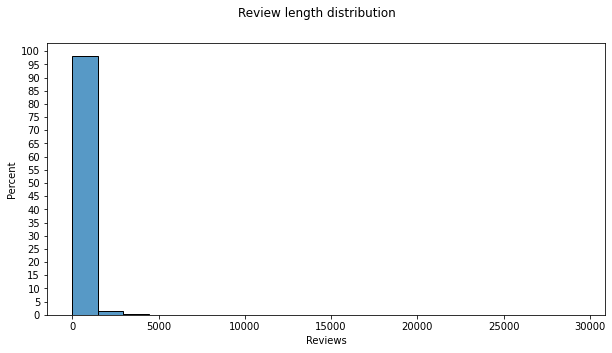

In [ ]:
data.dropna(subset=['Reviews'], inplace=True)
# text length of Data

f, ax = plt.subplots(1, 1, figsize=(10, 5))
f.suptitle("Review length distribution")

sns.histplot(data=data['Reviews'].apply(lambda x: len(x)), ax=ax, bins=20, stat='percent')
ax.set_yticks(np.arange(0, 105, 5))

plt.show()

In [ ]:
# see percentage of long reviews

long_review = data['Reviews'].apply(lambda x: False if len(x) < 2000 else True)
print(f"Percentage of Review length >= 2000: {long_review.sum() / len(long_review) * 100}%")

Percentage of Review length >= 2000: 1.0205955850721884%


Insights:
- Too long texts not meaningful and increase computation cost
- only 1% of Data, so drop those rows

In [ ]:
data.drop(data[data['Reviews'].apply(lambda x: len(x)) > 2000].index, inplace=True)

# Data Cleaning and Preprocessing

### Nan Values and Target Variable

In [ ]:
# first NaN Values

data.dropna(subset=['Reviews'], inplace=True)
data['Price'].fillna(value=0, inplace=True)
data['Review Votes'].fillna(value=0, inplace=True)
data['Brand Name'].fillna(value='Unknown', inplace=True)

print(data.isnull().sum())

Product Name    0
Brand Name      0
Price           0
Rating          0
Reviews         0
Review Votes    0
dtype: int64


In [ ]:
# insert new column with target value

data['target'] = data['Rating'].apply(lambda x: 'bad' if x <= 2 else 'good')

### Rest of Preprocessing:

- Lowercase
- RegExp cleaning for punctuation etc.
- expand contractions
- tokenize
- remove stopwords

- Correct misspellings
- remove duplicate characters if needed (e.g. 'woooow')

- Normalization: Lemmatize

- consider sentence representations (include stopwords etc.)

In [ ]:
# initialize variables for cleaning

# initialize Spellchecker
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

stopword_set = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
tag_map = {"N":wordnet.NOUN, "V": wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

# regex for correcting words like 'woooow' -> SpellChecker cant because uses Levenshtein Distance 2
# searches for a word character groups and a replicate of one character assigned to group 2
# -> for 'coodiing' 1. 'cooding' 2. 'coding'

#repeat_pattern = re.compile(re.compile(r'(\w*)(\w)\2(\w*)'))
#match_substitution = r'\1\2\3'

# delete all duplicates at once -> works most of the time and faster
repeat_pattern = re.compile(re.compile(r'(\w)\1*'))
match_substitution = r'\1'

# pre_clean text for both word and sentence tokenizer
def pre_clean_text(text):
    # split attached words -> capital + at last one lower case + arbitrary other characters till the first capital again
    no_attached = " ".join(re.split(r'([A-Z][a-z]+[^A-Z]*)', text))
    # lowercase
    lowercase = no_attached.lower()
    # remove links (first just www in to https, then everything with http until the next whitespace)
    temp = re.sub(r'www','https',lowercase)
    nolinks = re.sub(r'http[^\s]+','',temp)
    # combine words like "wi-fi"
    nolinks = re.sub(r'([\w]+)(\s-\s|-)([\w]+)',r'\1\3',nolinks)
    # remove numbers
    no_num = re.sub(r'[\d]+', '', nolinks)
    # expanding apostrophes
    pre_cleaned = remove_contractions(no_num)

    return pre_cleaned

# if features like CountVectors used
def word_process(pre_cleaned):
  # remove every punctuation etc. and replace with whitespaces
  no_punct = re.sub(r'[^\w]+', ' ', pre_cleaned)
  # tokenize
  tokenized = word_tokenize(no_punct)    
  # remove standard stopwords
  final = [word for word in tokenized if word not in stopword_set]
  return final

# for features like sentence embeddings
def sent_process(pre_cleaned):
  sentences = sent_tokenize(pre_cleaned)
  for i, sentence in enumerate(sentences):
    # remove punctuation now
    sentence = re.sub(r'[^\w]+', ' ', sentence).strip()
    # correct spellings
    sentence = " ".join(spellCorrection(sentence.split(" ")))
    sentences[i] = sentence

  return sentences

# function to remove contractions (no library used, but can't handle ambiguity
def remove_contractions(phrase):
      # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase


def spellCorrection(cleaned_text):
    for i, word in enumerate(cleaned_text):
        # lookup suggestions, include_unknown=False -> dont include unchanged word if nothing found
        # just include TOP -> closest with highest frequency
        suggestions = sym_spell.lookup(word, Verbosity.TOP,
                                        max_edit_distance=2, include_unknown = False)
        # append correction if found
        if suggestions:
            cleaned_text[i] = suggestions[0].term
        # if not try to delete duplicates first
        else:
            # delete duplicate letters
            del_duplicate = repeat_pattern.sub(match_substitution, word)
            suggestions = sym_spell.lookup(del_duplicate, Verbosity.TOP,
                                        max_edit_distance=2, include_unknown = False)
            # if word exists after removal -> append; otherwise skip
            if suggestions:
                cleaned_text[i] = suggestions[0].term

    return cleaned_text

# normalization: lemmatizing; text exspected as array
def normalize_text(corrected_text):
    # define part of speech for better lemmatizing
    pos_tagged = nltk.pos_tag(corrected_text)

    # convert treebank tags (returned by pos_tag()) to wordnet tags. just consider first letter
    return " ".join([lemmatizer.lemmatize(word, tag_map.get(tag[0], wordnet.NOUN)) for word, tag in pos_tagged])


data['clean_text'] = data['Reviews'].apply(pre_clean_text)
data['clean_sentences'] = data['clean_text'].apply(sent_process)
data['clean_text'] = data['clean_text'].apply(word_process)
data['clean_text'] = data['clean_text'].apply(spellCorrection)
data['clean_text'] = data['clean_text'].apply(normalize_text)
data.reset_index(drop=True, inplace=True)
data['clean_text'].head()

In [ ]:
from ast import literal_eval
if COLAB:
  data = pd.read_csv('./drive/MyDrive/cleaned_modified.csv')
  data['clean_sentences'] = data['clean_sentences'].apply(literal_eval)
  data['clean_text'] = data['clean_text'].apply(literal_eval)
else:
  data = pd.read_csv('./inputdata/cleaned_reviews.csv')
  data['clean_sentences'] = data['clean_sentences'].apply(literal_eval)
  data['clean_text'] = data['clean_text'].apply(literal_eval)
    
# some clean_text/clean_sentences values now Null?
print(f"Empty lists in clean text: {len(data) - data['clean_text'].map(bool).sum()}")
print(f"Empty lists in clean sentences: {len(data) - data['clean_sentences'].map(bool).sum()}")
data = data[data['clean_text'].map(bool)]
data = data[data['clean_sentences'].map(bool)]

data.info()


Empty lists in clean text: 70
Empty lists in clean sentences: 55
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400647 entries, 0 to 400771
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Product Name          400647 non-null  object 
 1   Brand Name            400647 non-null  object 
 2   Price                 400647 non-null  float64
 3   Rating                400647 non-null  int64  
 4   Reviews               400647 non-null  object 
 5   Review Votes          400647 non-null  float64
 6   target                400647 non-null  object 
 7   clean_text            400647 non-null  object 
 8   clean_sentences       400647 non-null  object 
 9   raw_length            400647 non-null  int64  
 10  cleaned_word_number   400647 non-null  int64  
 11  relative_punctuation  400647 non-null  float64
 12  relative_capitals     400647 non-null  float64
dtypes: float64(4), int64(3), object(6)
memo

# EDA

### Target Distribution

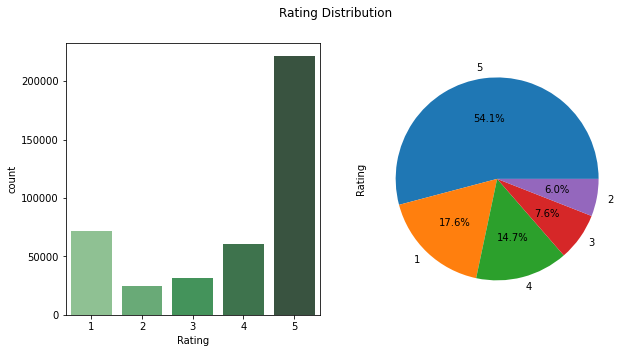

In [ ]:
# distribution of target variable rating

f, ax = plt.subplots(1, 2, figsize = (10, 5))
f.suptitle('Rating Distribution')
data['Rating'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
sns.countplot(data = data, x = 'Rating', palette='Greens_d', ax=ax[0])
plt.show()

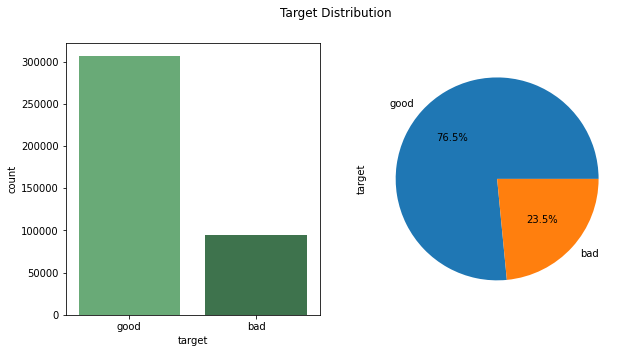

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (10, 5))
f.suptitle('Target Distribution')
data['target'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
sns.countplot(data = data, x = 'target', palette='Greens_d', ax=ax[0])
plt.show()

Insights:
- Data (not highly) unbalanced: keep in mind during splits or training
- if not whole dataset is used, use stratified sampling

### Brand Proportion

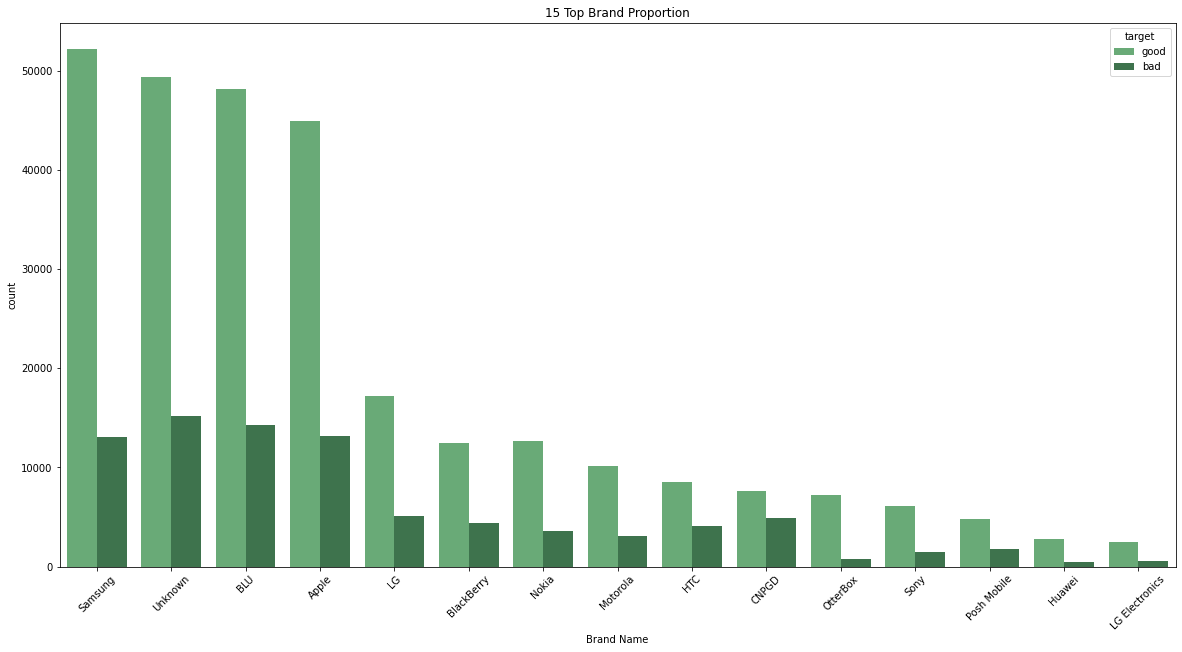

In [ ]:
# number of reviews per brand, also with respect to Target

plt.figure(figsize=(20, 10))
plt.title("15 Top Brand Proportion")
sns.countplot(data=data, x='Brand Name', hue='target', palette='Greens_d', order=data['Brand Name'].value_counts().iloc[:15].index)
plt.xticks(rotation=45)
plt.show()

In [ ]:
num_top_three = data['Brand Name'][data['Brand Name'].apply(lambda x: x in{'Samsung', 'BLU', 'Apple'})].value_counts()
print(f"Proportion of Samsung, BLU and Apple Reviews:\n{num_top_three / len(data) * 100}")

Proportion of Samsung, BLU and Apple Reviews:
Samsung    15.946987
BLU        15.249404
Apple      14.175805
Name: Brand Name, dtype: float64


Insights:
- No major differences in Target distribution with respect to brands

-> even if included wouldnt have an strong impact if data is balanced

- 3 Brands dominate Data (almost half)

### Review Length

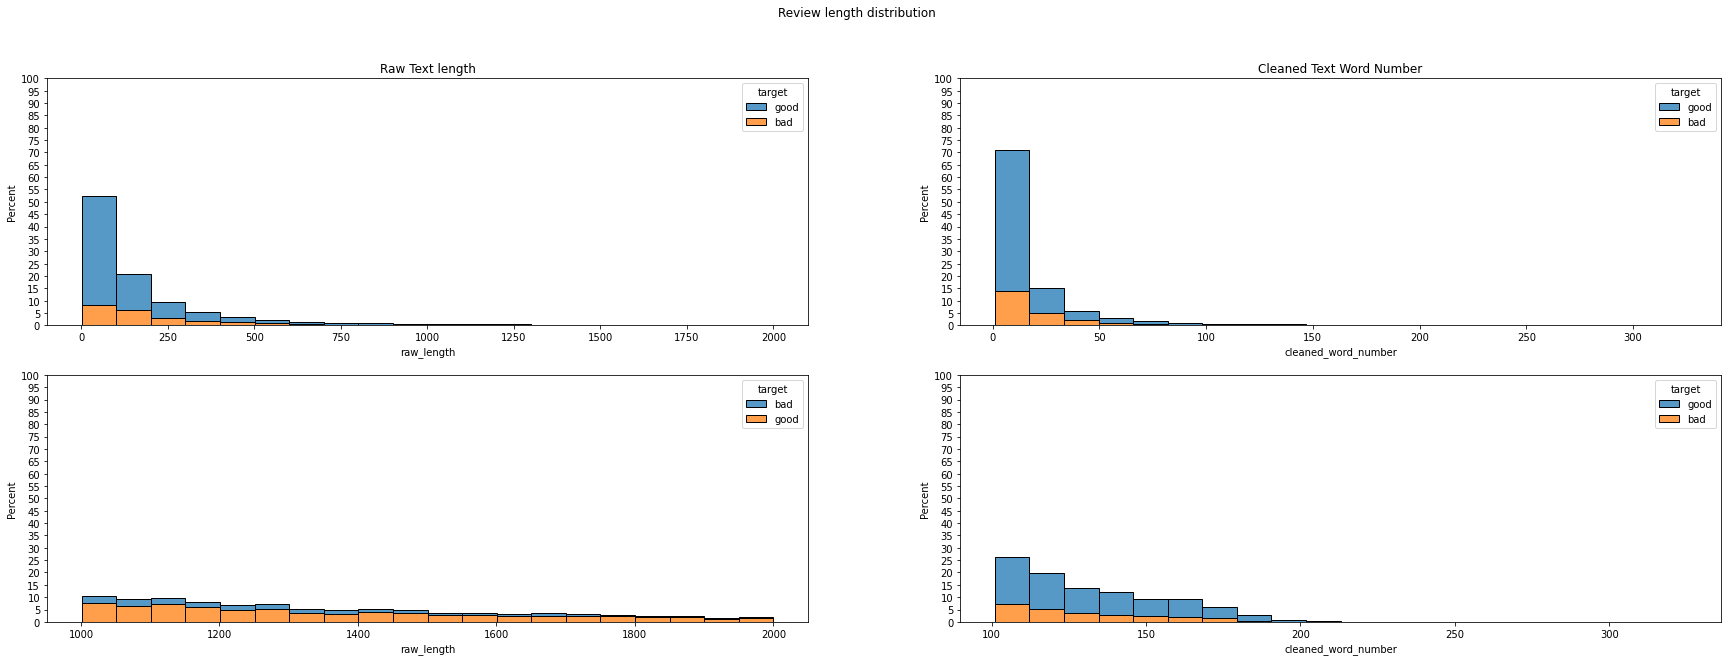

In [ ]:
# closer look to length of remaining data 
data['raw_length'] = data['Reviews'].apply(lambda x: len(x))
data['cleaned_word_number'] = data['clean_text'].apply(lambda x: len(x))

raw_threshold = 1000
word_threshold = 100

f, ax = plt.subplots(2, 2, figsize=(30, 10))
f.suptitle("Review length distribution")

sns.histplot(data=data,x='raw_length', ax=ax[0, 0], bins=20, stat='percent', multiple='stack', hue='target')
ax[0, 0].set_yticks(np.arange(0, 105, 5))
ax[0, 0].set_title("Raw Text length")

sns.histplot(data=data,x='cleaned_word_number' ,ax=ax[0, 1], bins=20, stat='percent', multiple='stack', hue='target')
ax[0, 1].set_yticks(np.arange(0, 105, 5))
ax[0, 1].set_title("Cleaned Text Word Number")

sns.histplot(data=data[data['raw_length'] > raw_threshold],x='raw_length', ax=ax[1, 0], bins=20, stat='percent', multiple='stack', hue='target')
ax[1, 0].set_yticks(np.arange(0, 105, 5))

sns.histplot(data=data[data['cleaned_word_number'] > word_threshold],x='cleaned_word_number' ,ax=ax[1, 1], bins=20, stat='percent', multiple='stack', hue='target')
ax[1, 1].set_yticks(np.arange(0, 105, 5))

plt.show()

In [ ]:
# see percentage of long reviews

print(f"Percentage of Review length >= {raw_threshold}: {len(data[data['raw_length'] > raw_threshold]) / len(data) * 100}%")
print(f"Percentage of cleaned word number >= {word_threshold}: {len(data[data['cleaned_word_number'] > word_threshold]) / len(data) * 100}%")

Percentage of Review length >= 1000: 2.602079808182988%
Percentage of cleaned word number >= 100: 2.1450005737907056%


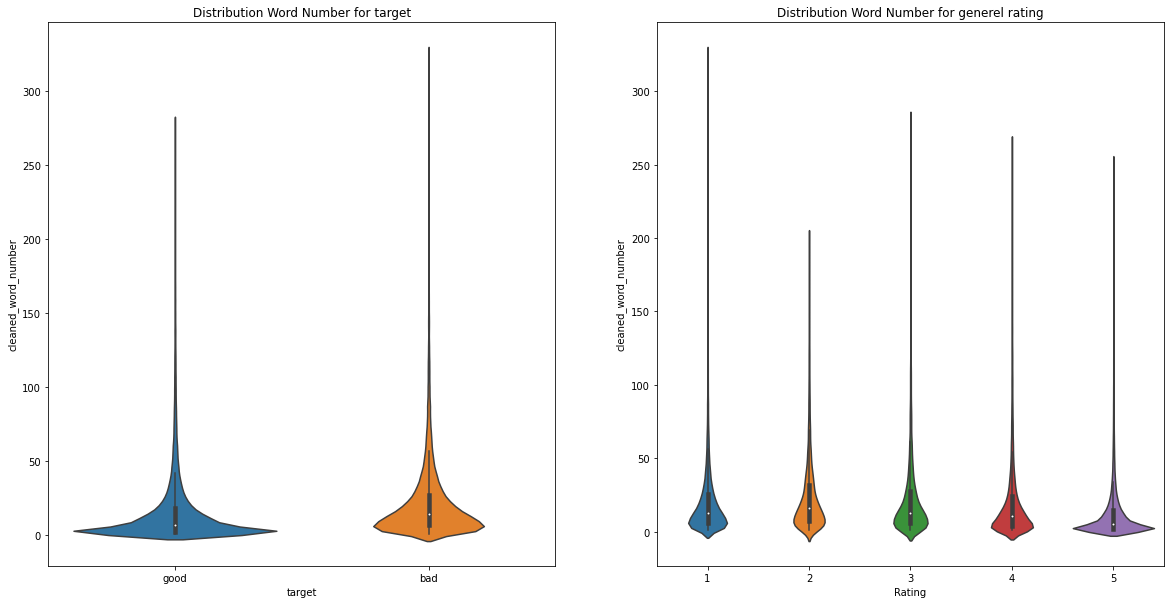

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.violinplot(data=data, x='target', y='cleaned_word_number', ax=ax[0])
sns.violinplot(data=data, x='Rating', y='cleaned_word_number', ax=ax[1])

ax[0].set_title("Distribution Word Number for target")
ax[1].set_title("Distribution Word Number for generel rating")
plt.show()

Insights:
- Target almost evenly distributed over text length
- very positive reviews (5*) tend to have very short review length
- very small subset has word review length greater 100

In [ ]:

data.drop(data[data['cleaned_word_number'].apply(lambda x: x > 100)].index, inplace=True)

### N-grams

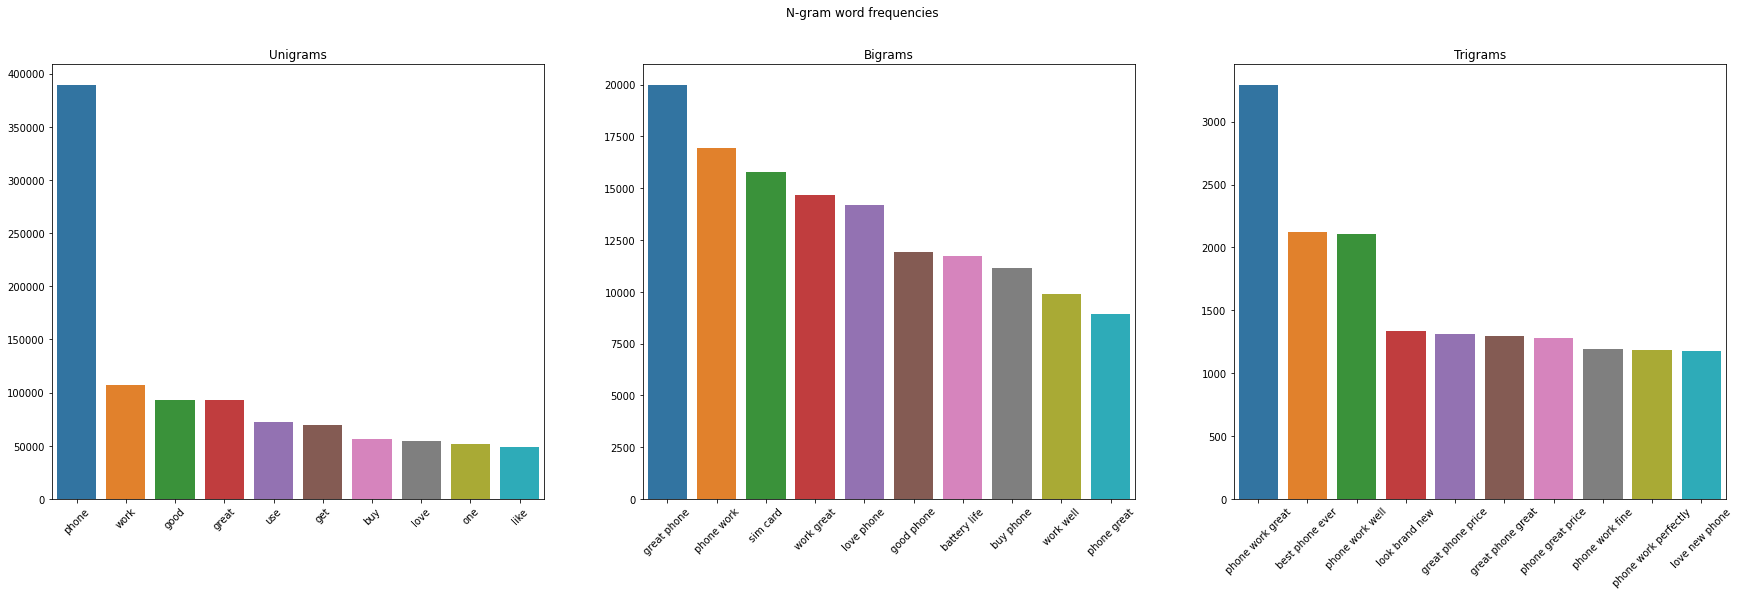

In [ ]:
def get_ngram_frequency(reviews, n, topwords):
    # to be able to pass CountVectorizer a list of tokens instead of string
    def dummy(doc):
        return doc
    vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, ngram_range=(n, n)).fit(reviews)
    bow = vectorizer.transform(reviews)
    frequencies = bow.sum(axis=0)
    # map index to word
    mapped_frequencies = [(word, frequencies[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    # sort by frequencies
    result = sorted(mapped_frequencies, key=lambda x: x[1], reverse=True)
    return result[:topwords]

unix, uniy = map(list, zip(*get_ngram_frequency(data['clean_text'], 1, 10)))
bix, biy = map(list, zip(*get_ngram_frequency(data['clean_text'], 2, 10)))
trix, triy = map(list, zip(*get_ngram_frequency(data['clean_text'], 3, 10)))
f, ax=plt.subplots(1, 3, figsize=(30, 8))
sns.barplot(x=unix, y=uniy ,ax=ax[0])
sns.barplot(x=bix, y=biy ,ax=ax[1])
sns.barplot(x=trix, y=triy ,ax=ax[2])
f.suptitle("N-gram word frequencies")
ax[0].set_title("Unigrams")
ax[1].set_title("Bigrams")
ax[2].set_title("Trigrams")
ax[0].set_xticklabels(unix, rotation=45)
ax[1].set_xticklabels(bix, rotation=45)
ax[2].set_xticklabels(trix, rotation=45)
plt.show()

Insights
- phone most frequently used word
- also bigrams usually with phone
- even trigrams usually with phone
- just 'positive' combinations because of imbalanced dataset

->  phone not meaningful for classification and therefore cut out

### Wordclouds

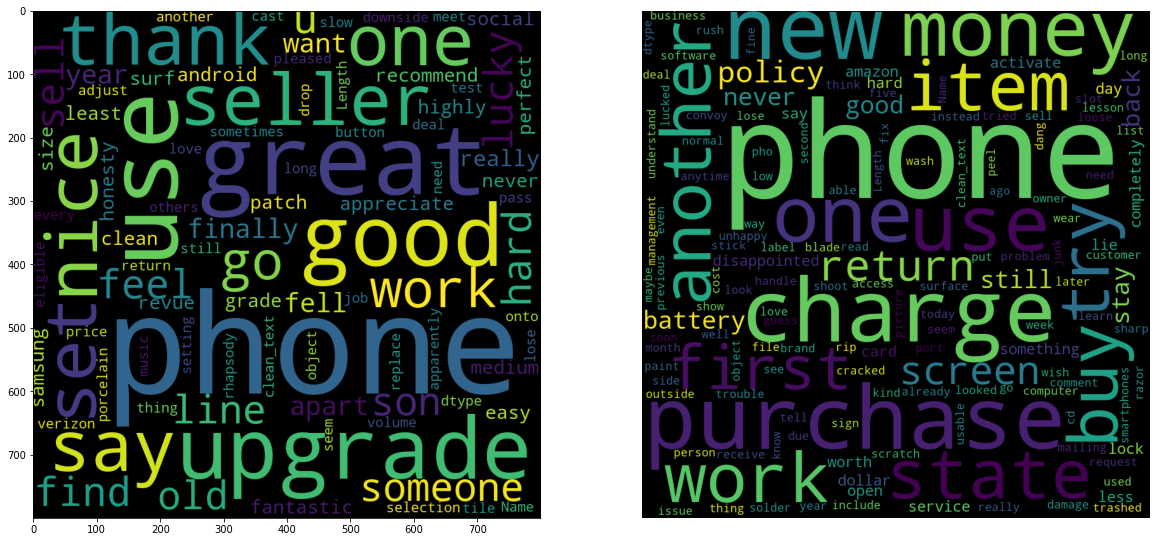

In [ ]:
positive_cloud = wordcloud.WordCloud(width = 800, height = 800).generate(str(data['clean_text'][data['target'] == 'good'].apply(lambda x: " ".join(x))))
negative_cloud = wordcloud.WordCloud(width = 800, height = 800).generate(str(data['clean_text'][data['target'] == 'bad'].apply(lambda x: " ".join(x))))

f, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(positive_cloud)
ax[1].imshow(negative_cloud)
plt.axis("off")

plt.show()

Insights:
- confirms that phone is not meaningful her -> dominant in both classes
- in positive class frequent words that indicate a positive review
- in negative class there are some (less) frequent words that indicate a negative review, but also many neutral ones (can go for both sides) or words where you need more context 

-> still cut out phone

-> also try word/sentence embeddings with stopwords to capture more context

### Votes with respect to Target and generell Ratings

In [ ]:
# compute vote average -> overall upvotes per rating/target divided by datalength
print("Average of Votes with respect to target value:")
target_avg = data[['target', 'Review Votes']].groupby('target').mean()
print(target_avg)

print("\nAverage of Votes with respect to ratings:")
ratings_avg = data[['Rating', 'Review Votes']].groupby('Rating').mean()
print(ratings_avg)

Average of Votes with respect to target value:
        Review Votes
target              
bad         1.988178
good        0.844942

Average of Votes with respect to ratings:
        Review Votes
Rating              
1           2.274463
2           1.132332
3           0.890917
4           0.808048
5           0.848410


Insights:
- bad reviews votes avg twice as high as for good reviews
- the lower the rating the higher the avg votes number

-> could be used as extra feature

# Feature Engineering

### Ideas for features:
Direct:
- Count vectors
- tf-idf vectors (for unigrams/bigrams etc.)
- Embeddings at different levels
- concatenate votes

Indirect:
- relative number of punctuation
- relative number of capital letters


-> relative counts and no review length because it wasnt an indicator for our target

-> no brand and price because focus on text and no bias. Brand was no good indicator anyway 



In [ ]:
# first cut out "phone"
data['clean_text'] = data['clean_text'].apply(lambda x: [el for el in x if el != 'phone'])

### Indirect Features:

##### Punctuation Ratio:

In [ ]:
# compute relative Punctuation and plot with respect to target

data['relative_punctuation'] = data['Reviews'].apply(lambda x: len([p for p in x if p in string.punctuation]) / len(x))

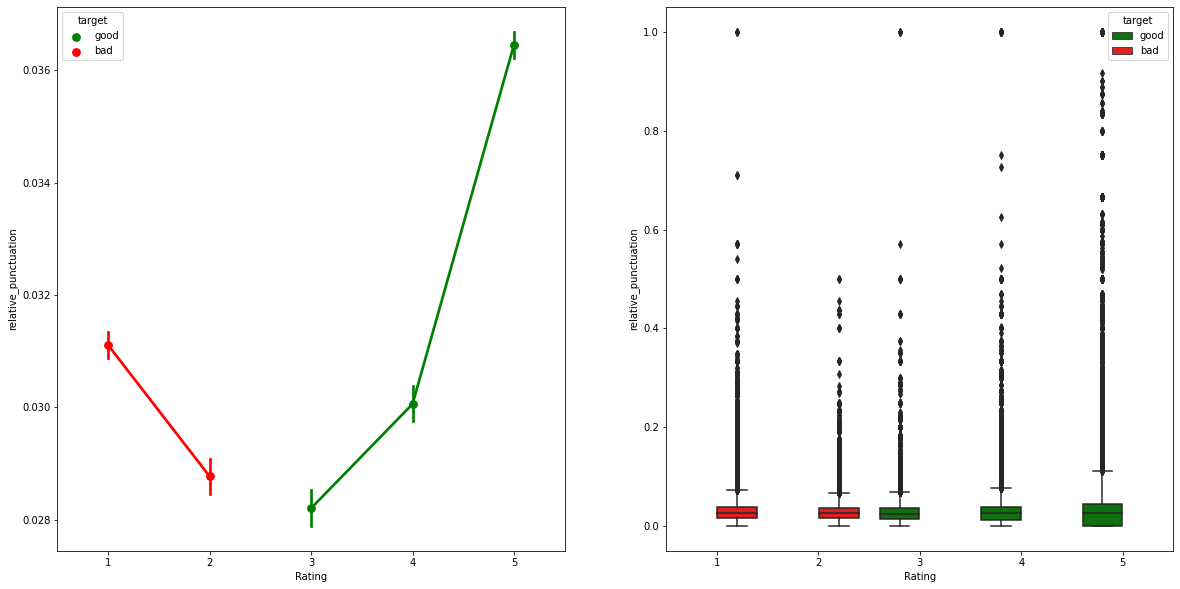

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.pointplot(data=data, x='Rating', y='relative_punctuation', hue='target', palette={'good':'g', 'bad':'r'}, ax=ax[0])
sns.boxplot(data=data, x='Rating', y='relative_punctuation', hue='target', palette={'good':'g', 'bad':'r'}, ax=ax[1])
plt.show()

Insight:
- punctuation ratio (at least the mean) tends to be higher for extrem cases (not significant though if you look at the y-scale)

-> since it is an indicator for really bad or really good ratings but not the overall sentiment its not added as a feature
- median for all ratings about the same, just outliers determine the difference


Capital Letters:

In [ ]:
# compute relative Punctuation and plot with respect to target

data['relative_capitals'] = data['Reviews'].apply(lambda x: len([p for p in x if p.isupper()]) / len(x))

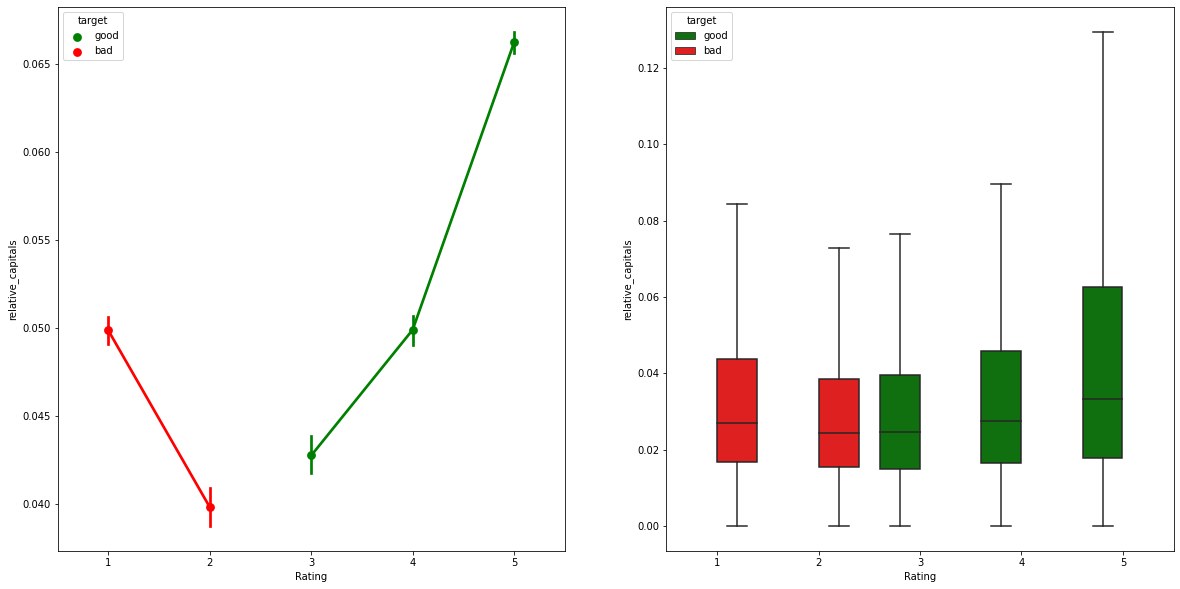

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.pointplot(data=data, x='Rating', y='relative_capitals', hue='target', palette={'good':'g', 'bad':'r'}, ax=ax[0])
sns.boxplot(data=data, x='Rating', y='relative_capitals', hue='target', palette={'good':'g', 'bad':'r'}, ax=ax[1], showfliers=False)
plt.show()

Insights:
- almost looks the same as punctuation (if you plot with outliers, here they are cutted out)
- really positive reviews tend to have more capital letters

-> could try this as feature

### Building Feature Vectors

In [ ]:
# first split data

y = data['target'].map({'good':1, 'bad':0})
# only cut out features we definitely wont use
X = data[['clean_text', 'clean_sentences', 'relative_capitals', 'Review Votes']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# just used as whole review
X_train['clean_sentences'] = X_train['clean_sentences'].apply(lambda x: ". ".join(x))

# use stratified 2-fold: enough data, but since undersampling is performed better avg
strat_kfold = StratifiedKFold(n_splits=2)

In [ ]:
def balance_data(X_train, y_train):
  # make sure index is not mixed up
  X_train.reset_index(drop=True, inplace=True)
  y_train.reset_index(drop=True, inplace=True)

  # Balance train data
  balance_selection = y_train.groupby(y_train, group_keys=False)
  balance_selection = balance_selection.apply(lambda x: x.sample(balance_selection.size().min()))

  # apply correct indices
  y_train_balanced = y_train.iloc[balance_selection.index].reset_index(drop=True)
  X_train_balanced = X_train.iloc[balance_selection.index].reset_index(drop=True)

  # shuffle data before use
  shuffle_indices = y_train_balanced.sample(frac=1).index
  y_train_balanced = y_train_balanced.iloc[shuffle_indices].reset_index(drop=True)
  X_train_balanced = X_train_balanced.iloc[shuffle_indices].reset_index(drop=True)

  return X_train_balanced, y_train_balanced

Combine tf-idf vector with indirect features

In [ ]:
import scipy.sparse

def tfidf_vectorize(X_train_balanced, X_valid):
  # use a mixture of uni-bi-grams
  # (bigrams would add 500k and trigrams about 1million more values)

  # to be able to pass tfidfVectorizer a list of tokens instead of string
  def dummy(doc):
      return doc

  tfidf_vec = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, ngram_range=(1, 1))

  tfidf_vec_train = tfidf_vec.fit_transform(X_train_balanced['clean_text'])
  tfidf_vec_val = tfidf_vec.transform(X_valid['clean_text'])

  # add vote counts + capital letters

  # convert to sparse matrix to concatenate
  indirect_feat_train = scipy.sparse.csr_matrix(X_train_balanced[['relative_capitals', 'Review Votes']].to_numpy())
  indirect_feat_val = scipy.sparse.csr_matrix(X_valid[['relative_capitals', 'Review Votes']].to_numpy())

  tfidf_combined_train = scipy.sparse.hstack([tfidf_vec_train, indirect_feat_train])
  tfidf_combined_val = scipy.sparse.hstack([tfidf_vec_val, indirect_feat_val])

  return tfidf_vec_train, tfidf_vec_val, tfidf_combined_train, tfidf_combined_val

def count_vectorize(X_train_balanced, X_valid):

  # to be able to pass CountVectorizer a list of tokens instead of string
  def dummy(doc):
      return doc

  count_vec = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, ngram_range=(1, 1))

  count_train = count_vec.fit_transform(X_train_balanced['clean_text'])
  count_val = count_vec.transform(X_valid['clean_text'])

  return count_train, count_val

Embeddings: Universal Sentence Encoder (Review Level)

In [ ]:
import tensorflow as tf

# load pre-trained encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def use_embedding(X_train_balanced, X_valid=None):
  # convert to series, because later models dont use dataframes
  if isinstance(X_train_balanced, pd.DataFrame):
    X_train_balanced = X_train_balanced['clean_sentences']
    if X_valid is not None:
      X_valid = X_valid['clean_sentences']
  # join sentences, as USE can work with paragraphs (but no multidimensional input)
  # do 5 runs each, as you might run out of memory
  batchsize = 30000

  embed_train = []
  runs_train = len(X_train_balanced) // batchsize 

  for i in range(runs_train):
    embed_train.append(embed(X_train_balanced.iloc[batchsize * i:batchsize * (i+1)].to_numpy()))

  embed_train.append(embed(X_train_balanced.iloc[batchsize * runs_train:].to_numpy()))

  # concatened results
  embedded_train = tf.concat(embed_train, 0)
  
  # perform for X_valid if provided
  if X_valid is not None:
    embed_val = []
    runs_val = len(X_valid) // batchsize
    for i in range(runs_val):
      embed_val.append(embed(X_valid.iloc[batchsize * i:batchsize * (i+1)].to_numpy()))

    embed_val.append(embed(X_valid.iloc[batchsize * runs_val:].to_numpy()))
    embedded_val = tf.concat(embed_val, 0)

    return embedded_train.numpy(), embedded_val.numpy()
  
  return embedded_train.numpy(), None

# Model Training

Models:
- Logistic Regression
- SGDClassifier (with Nystroem) -> too many samples for svc
- Naive Bayes
- XGBClassifier
- CatBoost

Features:
- Count Vectors + 2 indirect features
- tf-idf Vectors + 2 indirect features
- Universal Sentence Encoding + 2 indirect Features

Main Metric:
- no Accuracy -> due to imbalanced Dataset could give a false sense of a good classifier
- Recall of negative Class -> most important to detect bad reviews to improve
- F1 of negative class -> to balance, because precision still important


In [ ]:
# function for plotting confusion matrix
def plot_reports(y_test, y_pred):
  # get confusion matrix + classification report
  conf_mat = metrics.confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred, labels=[0, 1], 
                                       target_names=['bad', 'good'], 
                                       output_dict=True)
  # plot both in a figure
  f, ax = plt.subplots(1, 2, figsize=(25, 7))
  sns.set(font_scale=1.5)
  sns.heatmap(conf_mat, annot=True, cmap='Greens', square=True, fmt='d',
              xticklabels=['bad', 'good'], yticklabels=['bad', 'good'], ax=ax[0])
  ax[0].set(xlabel='Predicted', ylabel='Actual')
  ax[0].set_title('Confusion Matrix')

  # iloc because "support" wouldnt fit in heatmap
  sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True, 
              cmap='Greens', ax=ax[1])
  ax[1].set_title('Classification Report')

  plt.show()

# function for modeling
def modeling(clf, X_train, y_train, X_test, y_test, report_flag=False):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  # just get recall of negative class as this is more important
  recall_neg = recall_score(y_test, y_pred, average='binary', pos_label=0)
  f1_neg = f1_score(y_test, y_pred, average='binary', pos_label=0)

  # print classification report if requested
  if report_flag:
    plot_reports(y_test, y_pred)
    
  return recall_neg, f1_neg

randomstate = 2
classifier_names = ['Logistic Regression', 'Naive Bayes', 
                    'SGDClassifier (kernel approx.)', 'SGDClassifier', 
                    'XGBClassifier', 'CatBoost']

# numpy array for every report: (#classifiers) X (#feature representations) X (#metrics)
reports = np.zeros(shape=(len(classifier_names), 5, 2))


### sklearn Classifiers

Fold 0:
  Trainsamples: 160258
  Validationsamples: 160259
Training Fold 0 Classifier Logistic Regression:

Training Fold 0 Classifier Naive Bayes:

Training Fold 0 Classifier SGDClassifier (kernel approx.):

Training Fold 0 Classifier SGDClassifier:

Training Fold 0 Classifier XGBClassifier:

Training Fold 0 Classifier CatBoost:

Fold 1:
  Trainsamples: 160259
  Validationsamples: 160258
Last Fold Reports for every classifier, 5 feature representations each:
1. CountVectorizer
2. Tf-IdfVectorizer
3. Tf-IdfVectorizer + 2 more features
4. Universal Sentence Encoder Embedding
5. Universal Sentence Encoder Embedding + 2 more features
Training Fold 1 Classifier Logistic Regression:



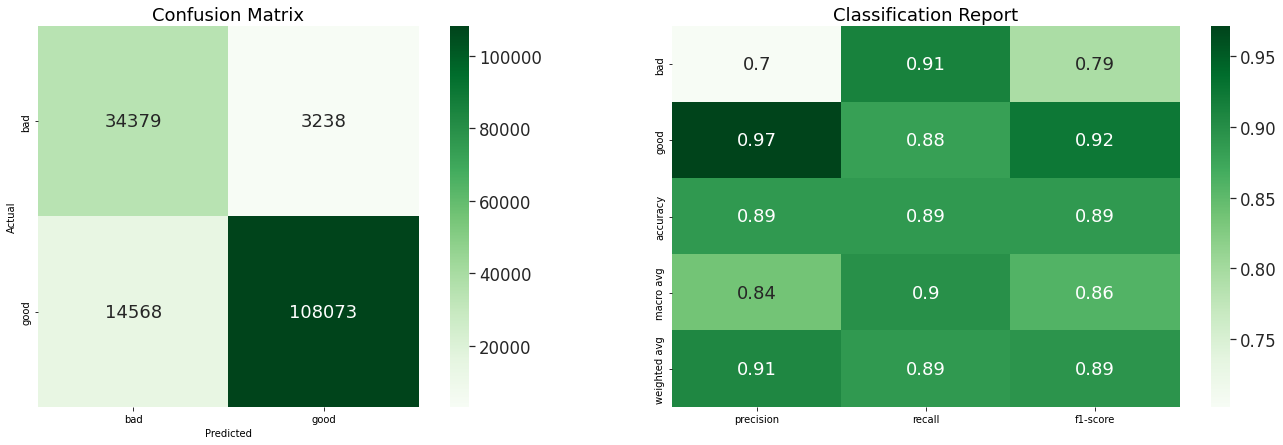

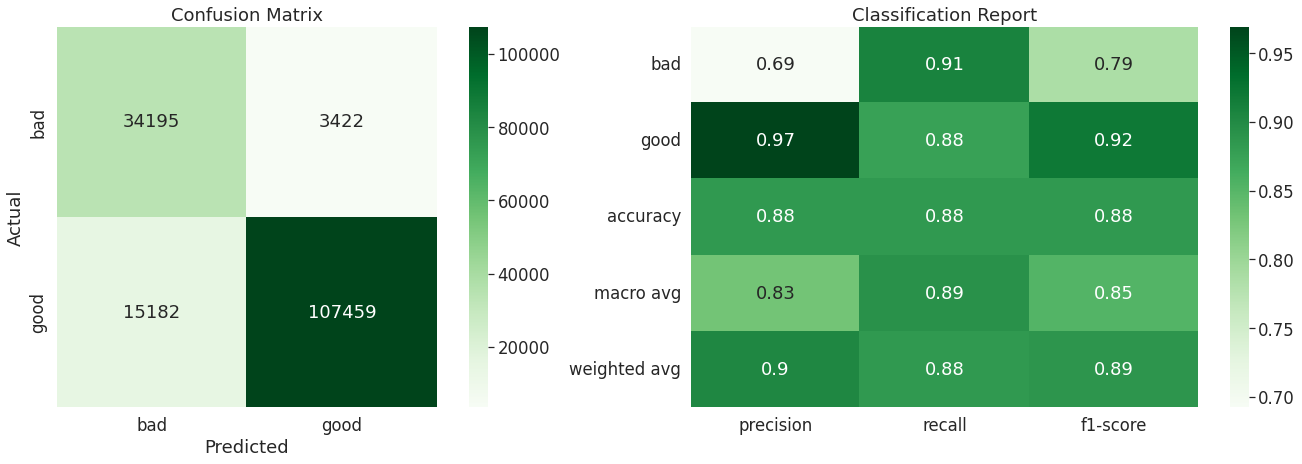

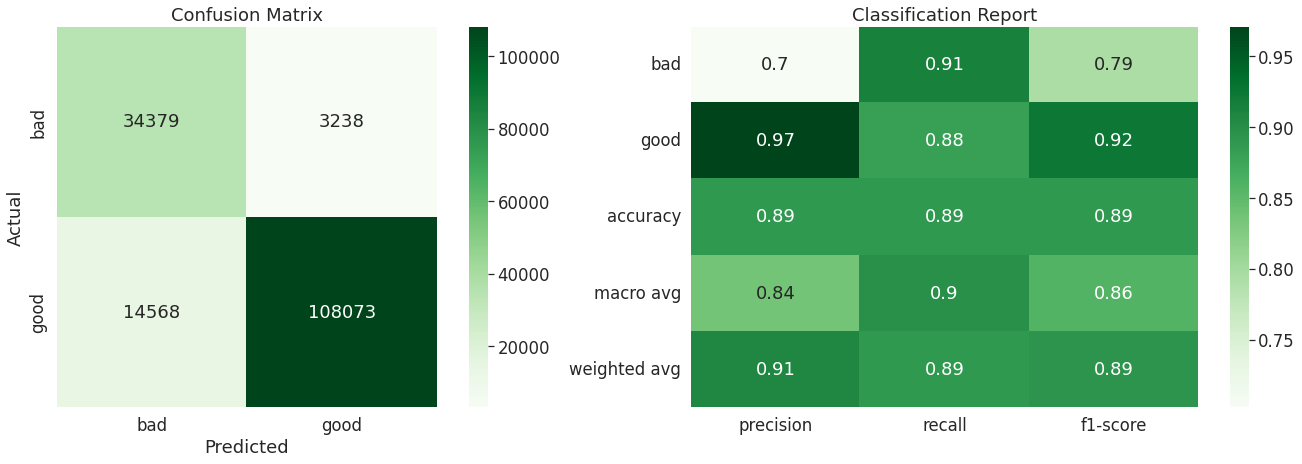

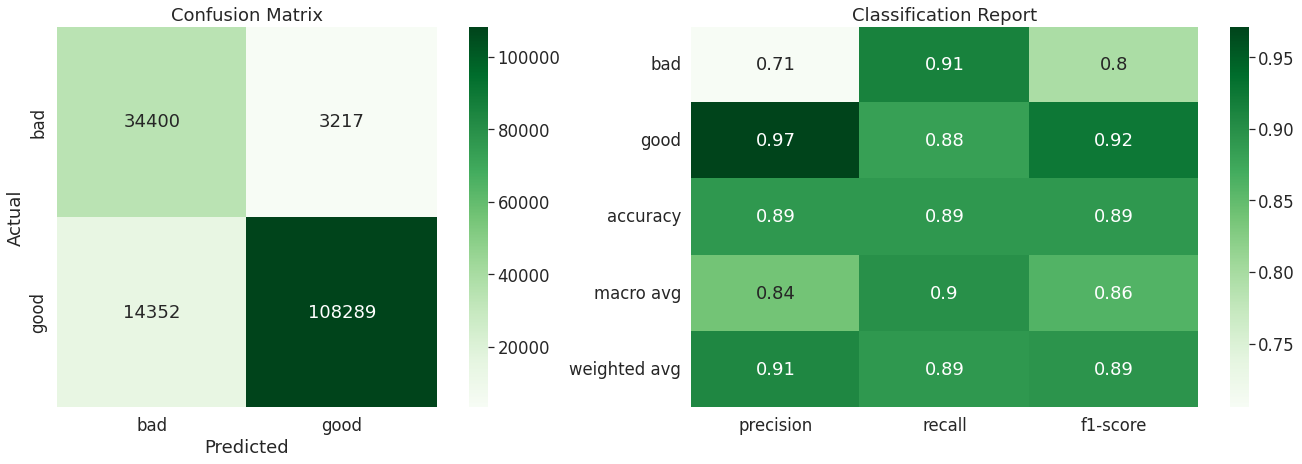

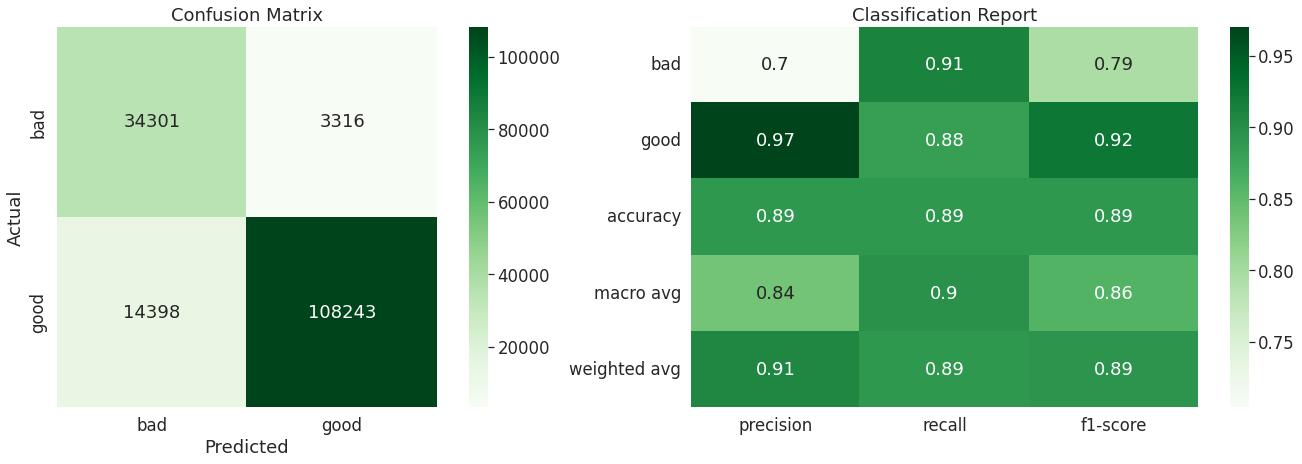

Training Fold 1 Classifier Naive Bayes:



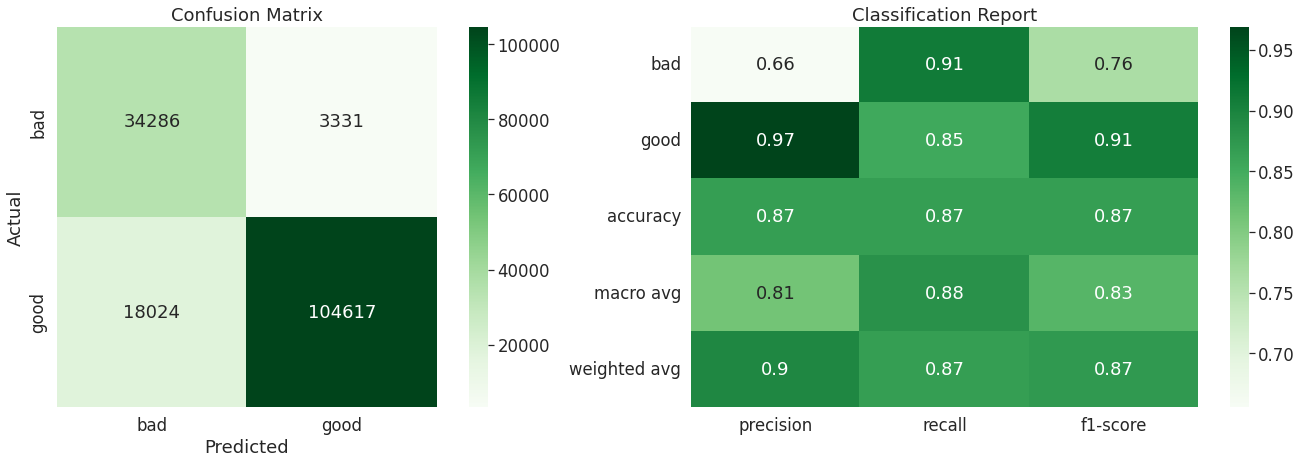

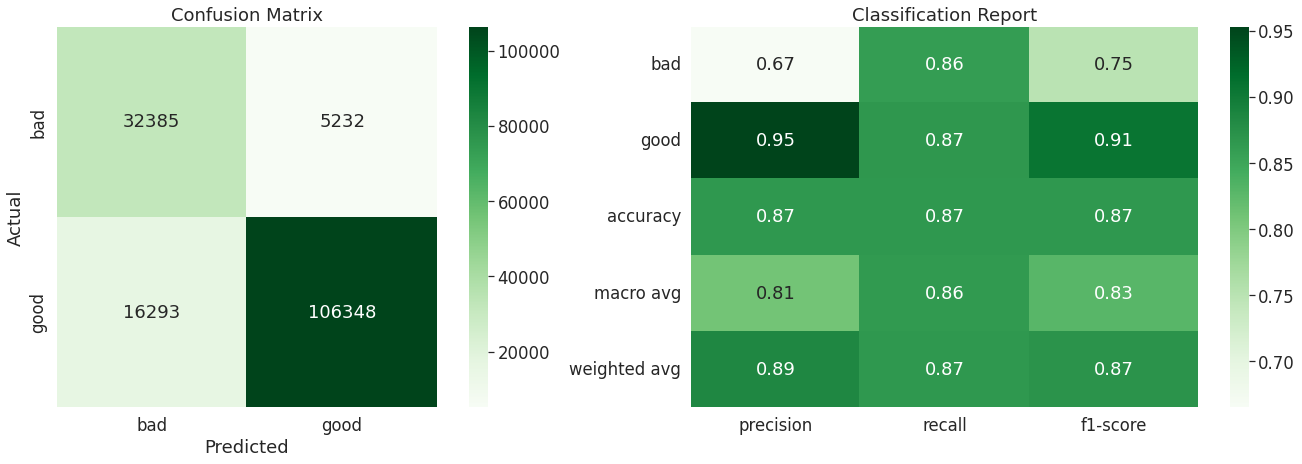

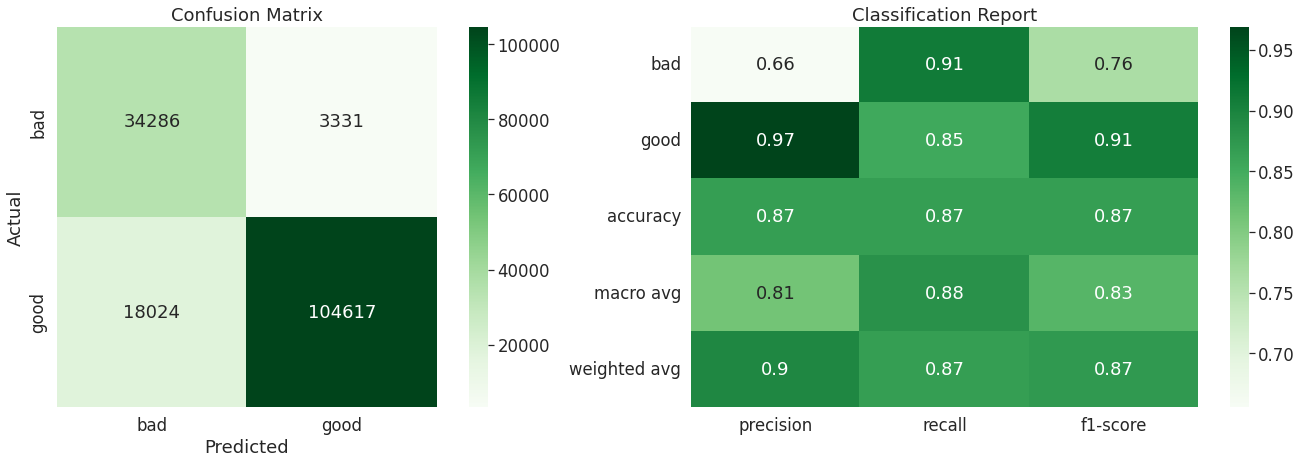

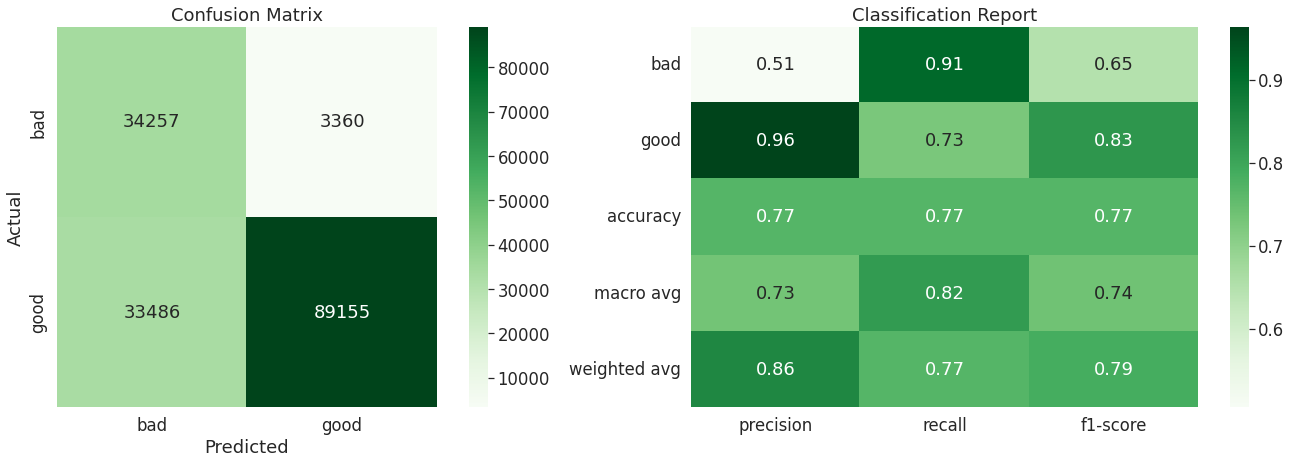

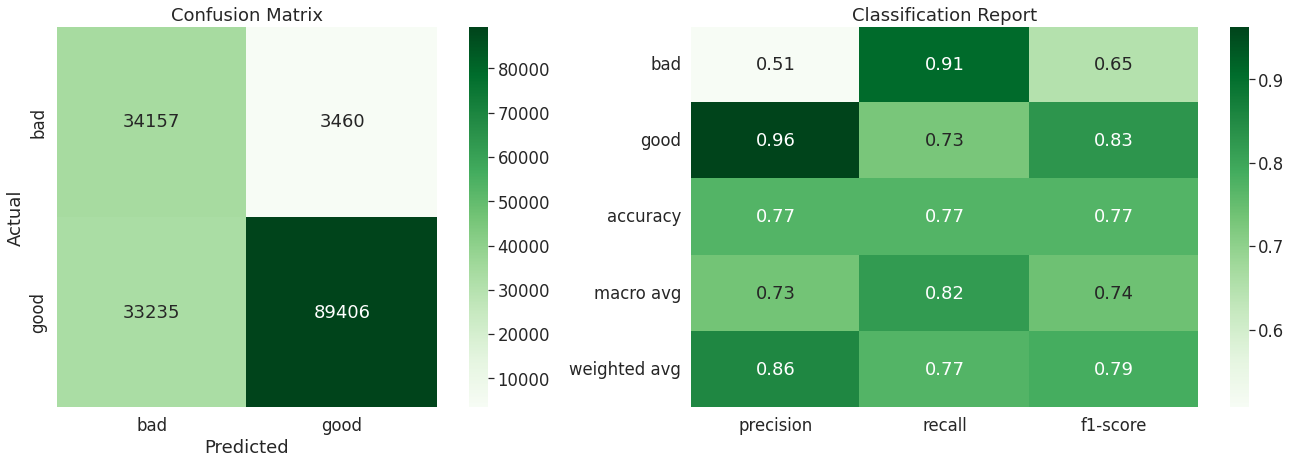

Training Fold 1 Classifier SGDClassifier (kernel approx.):



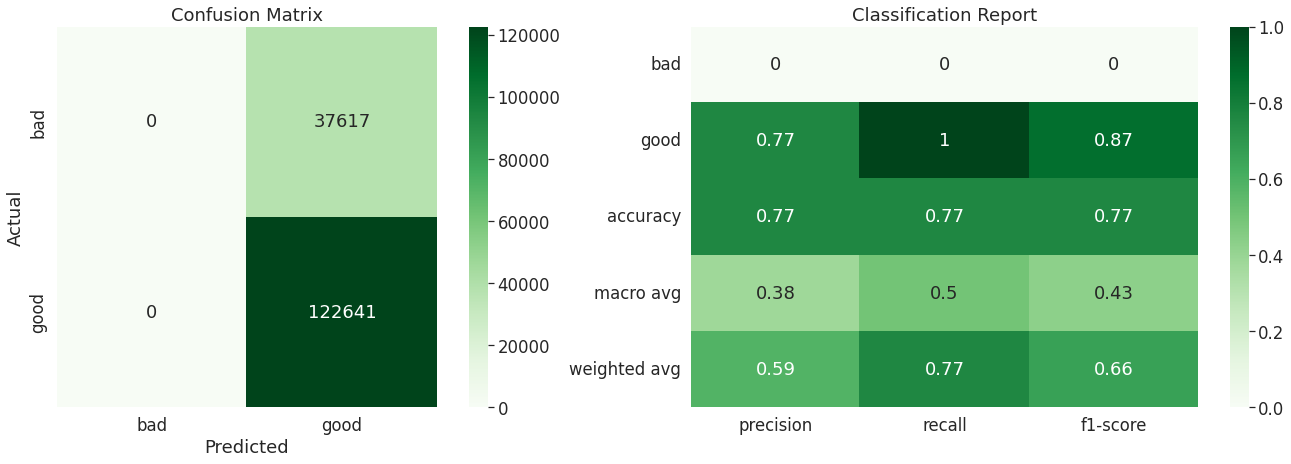

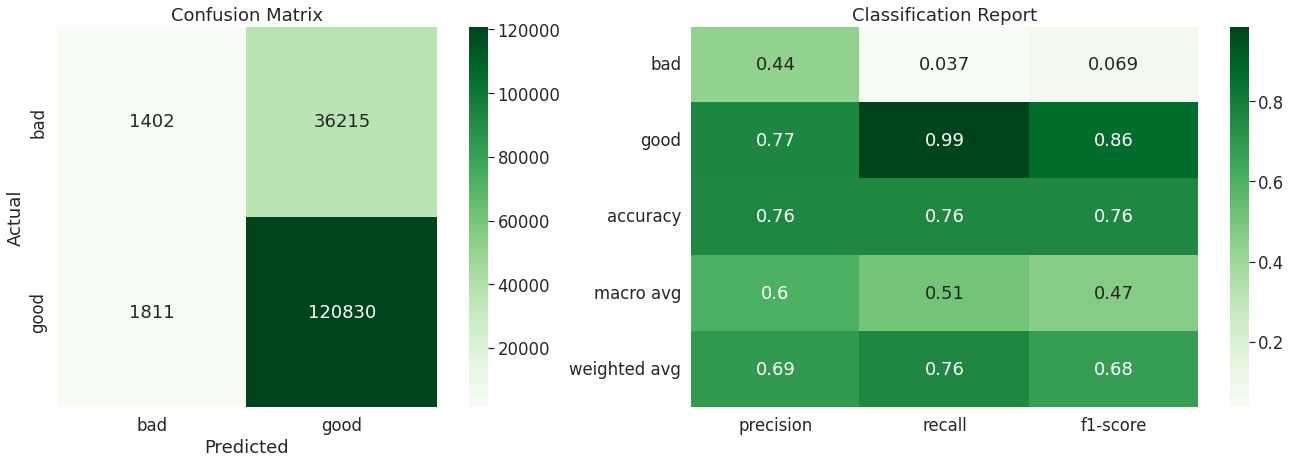

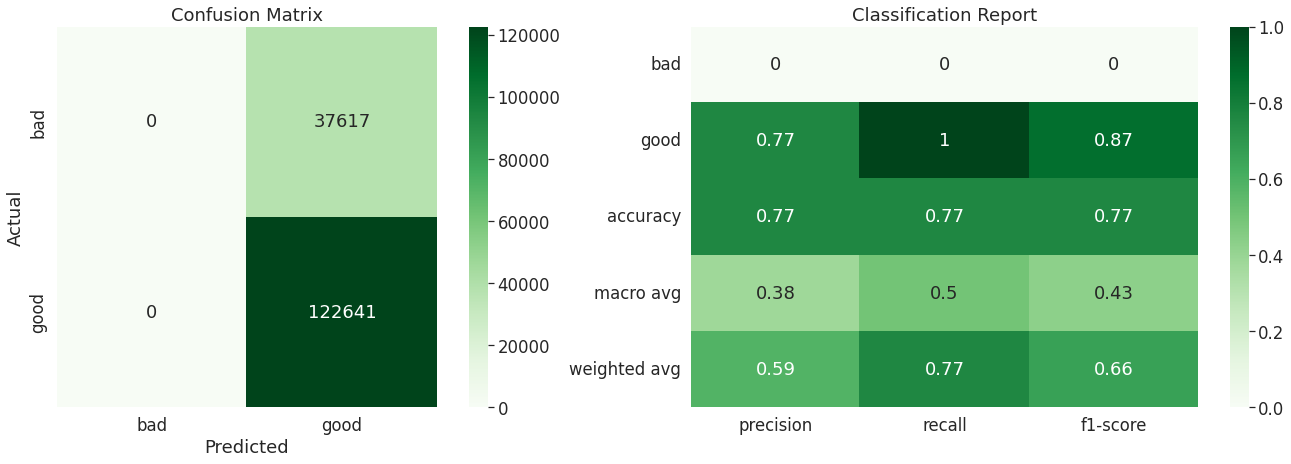

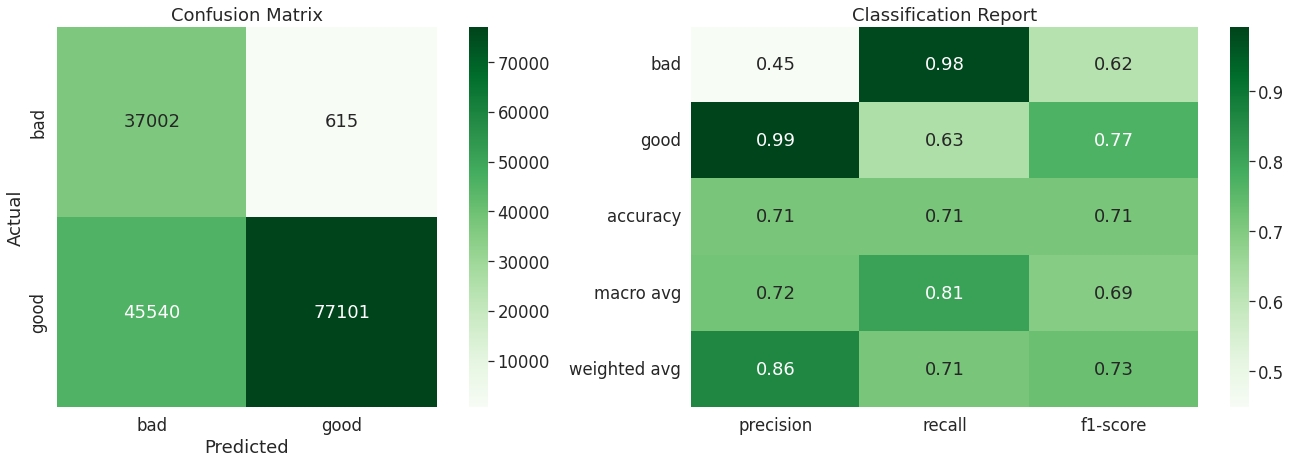

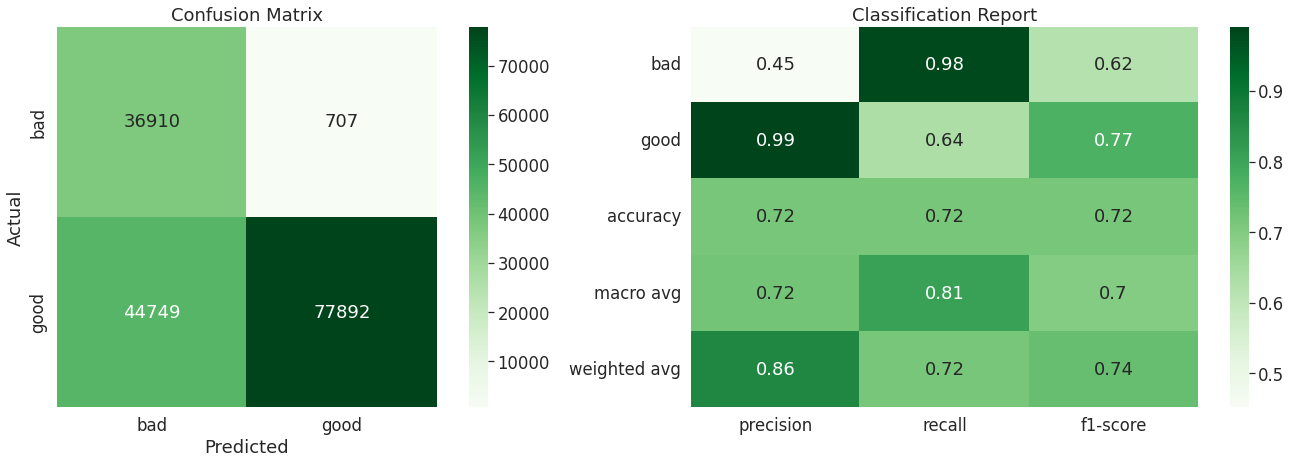

Training Fold 1 Classifier SGDClassifier:



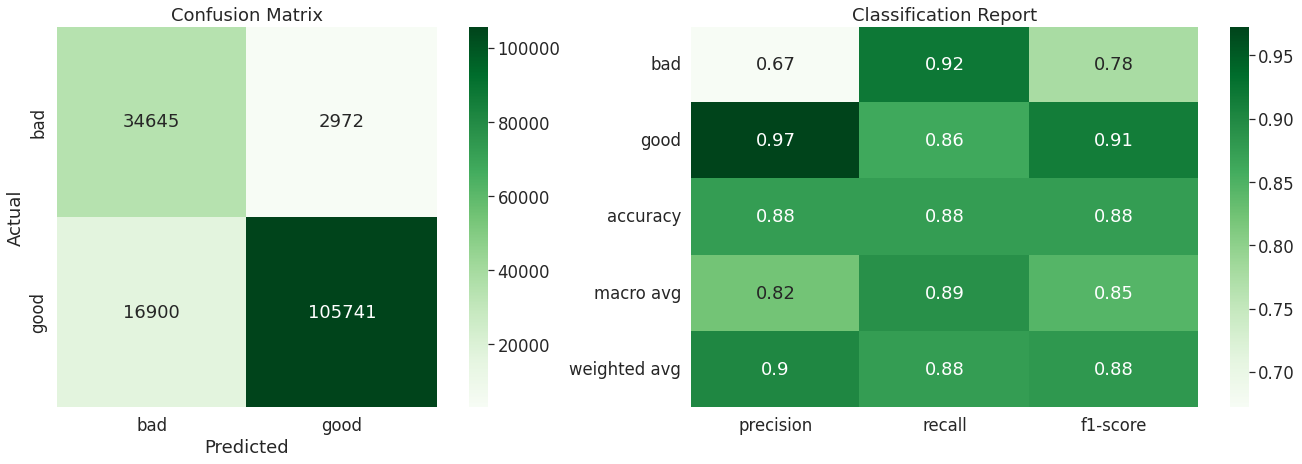

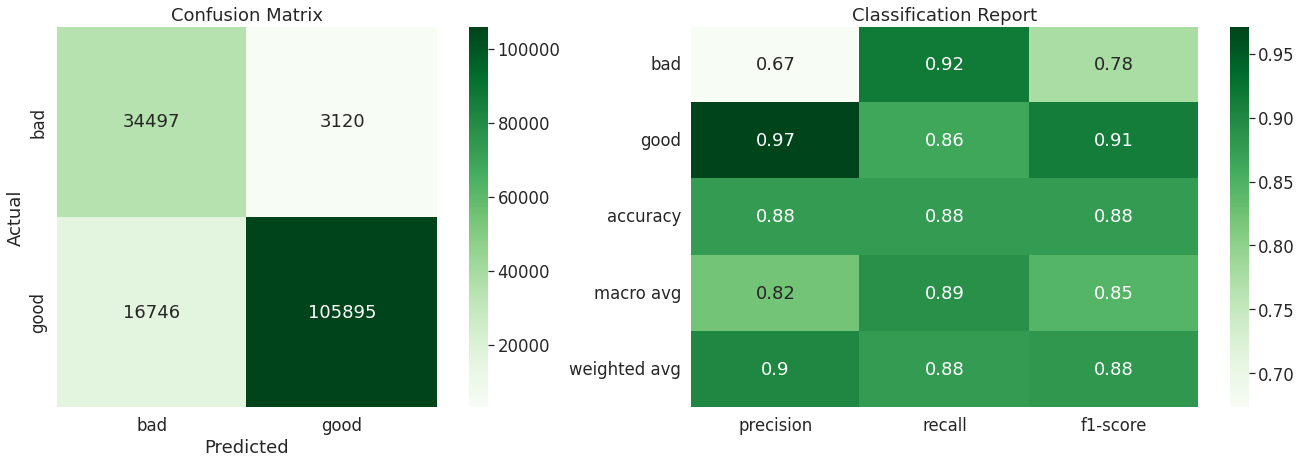

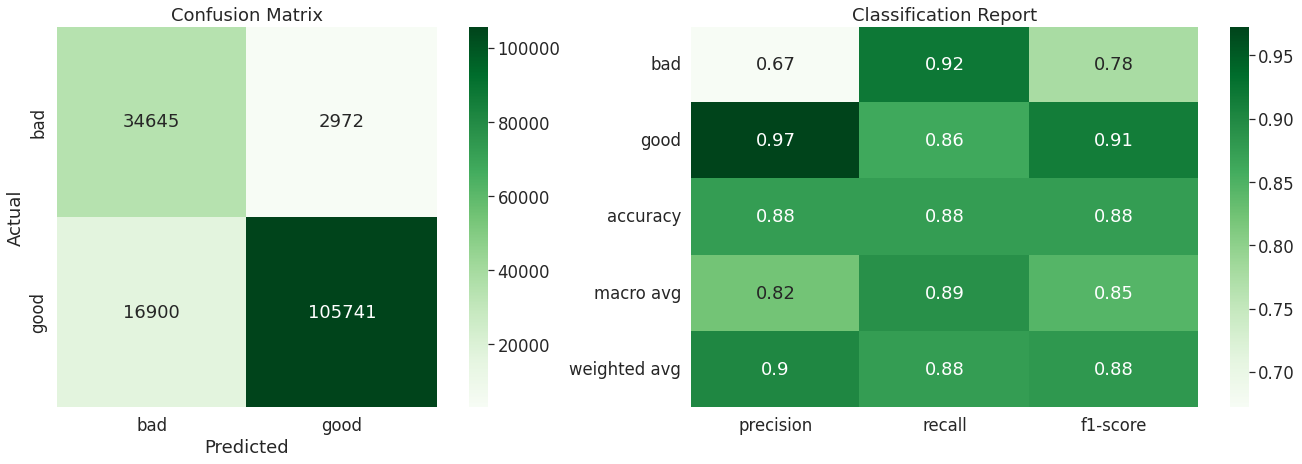

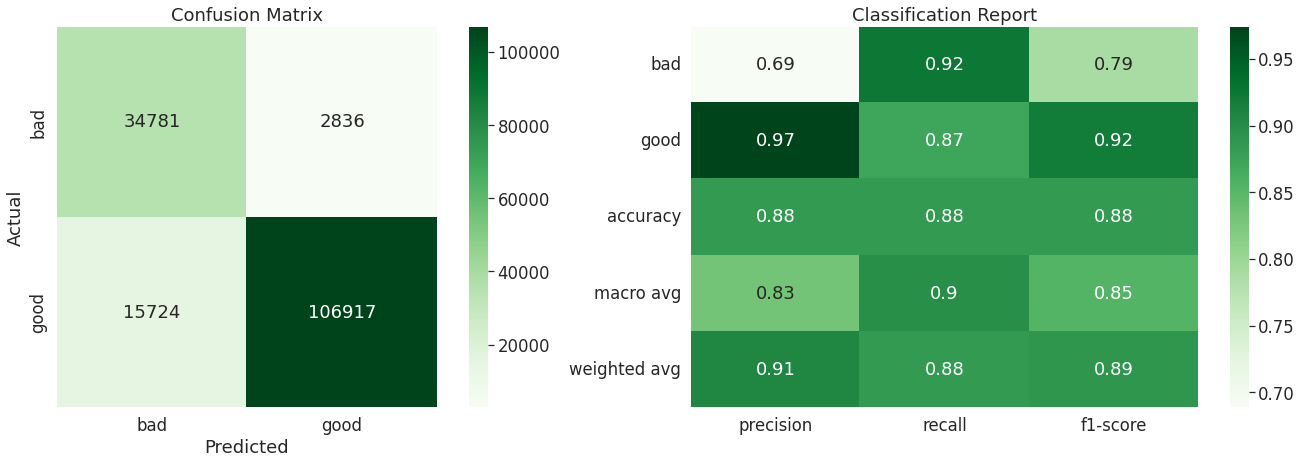

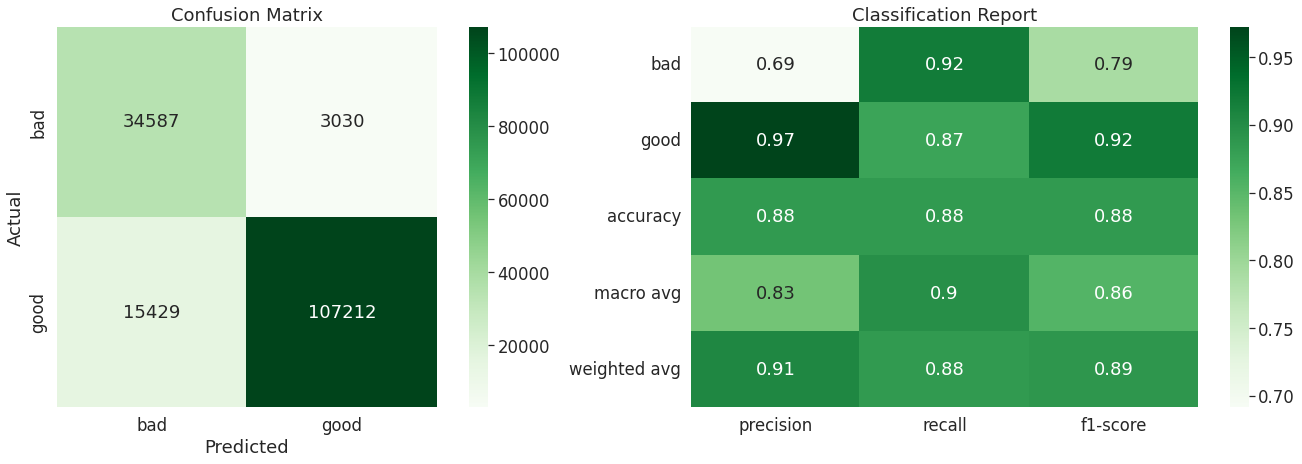

Training Fold 1 Classifier XGBClassifier:



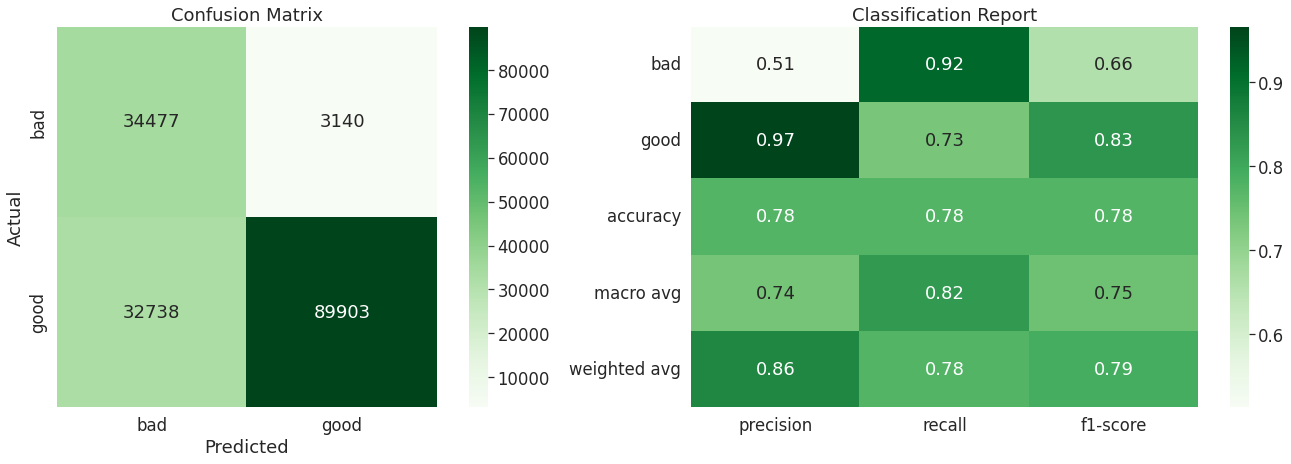

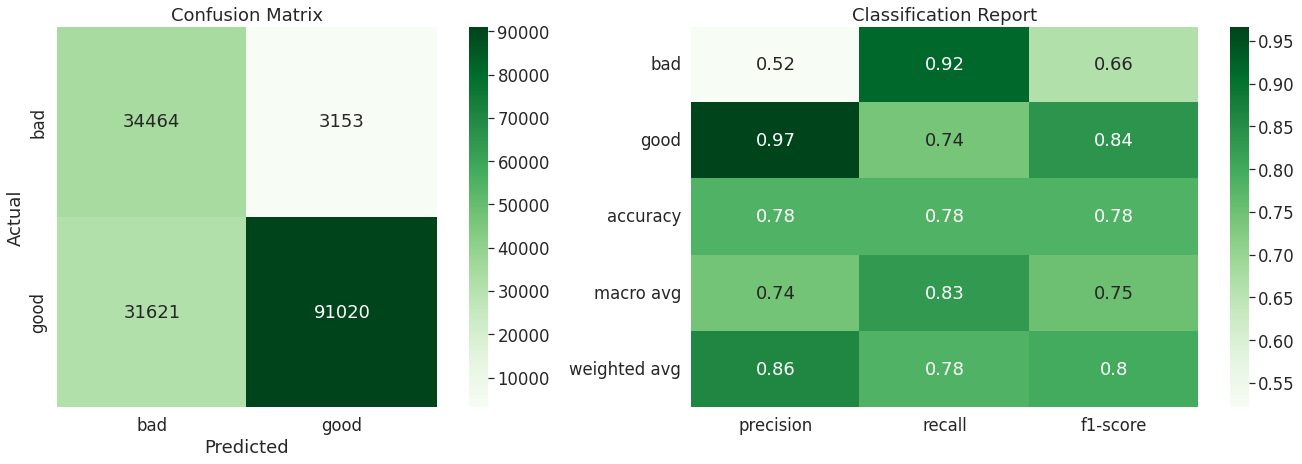

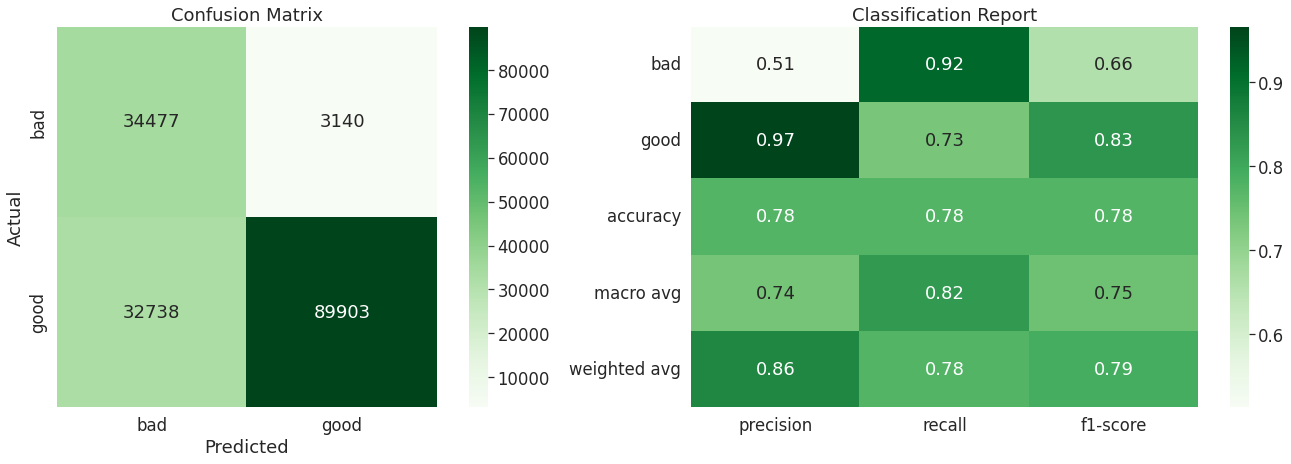

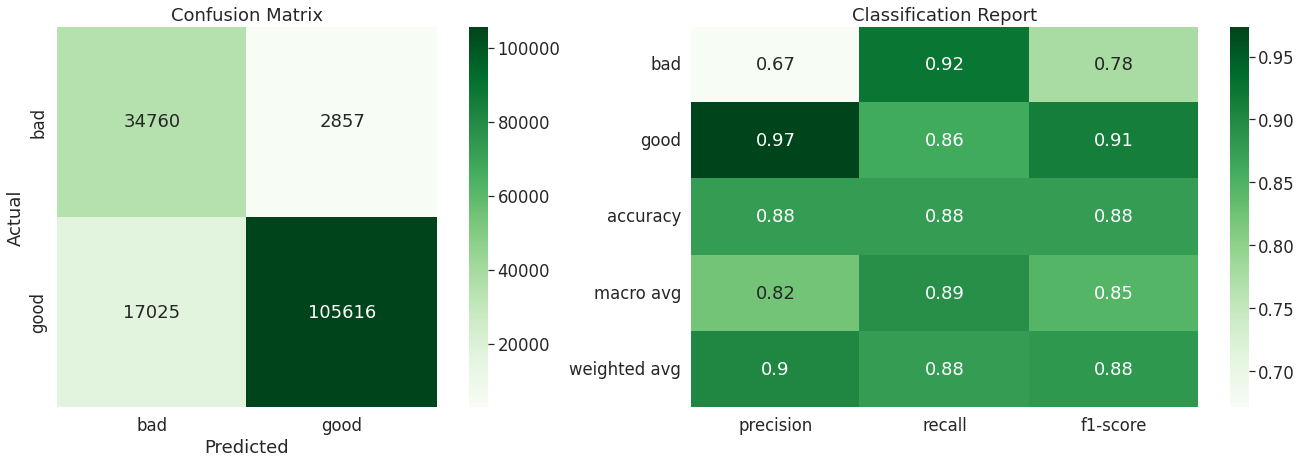

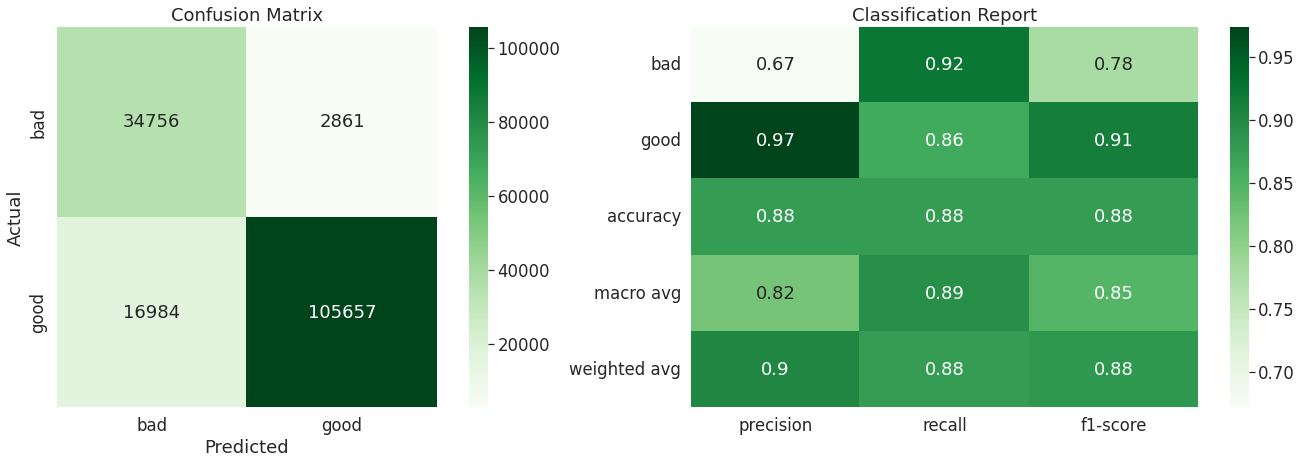

Training Fold 1 Classifier CatBoost:



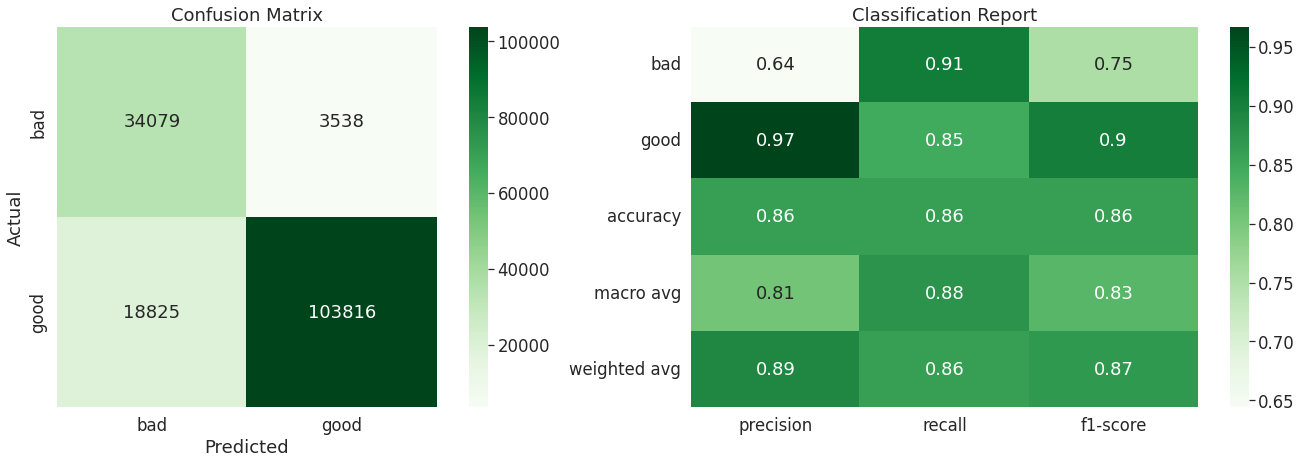

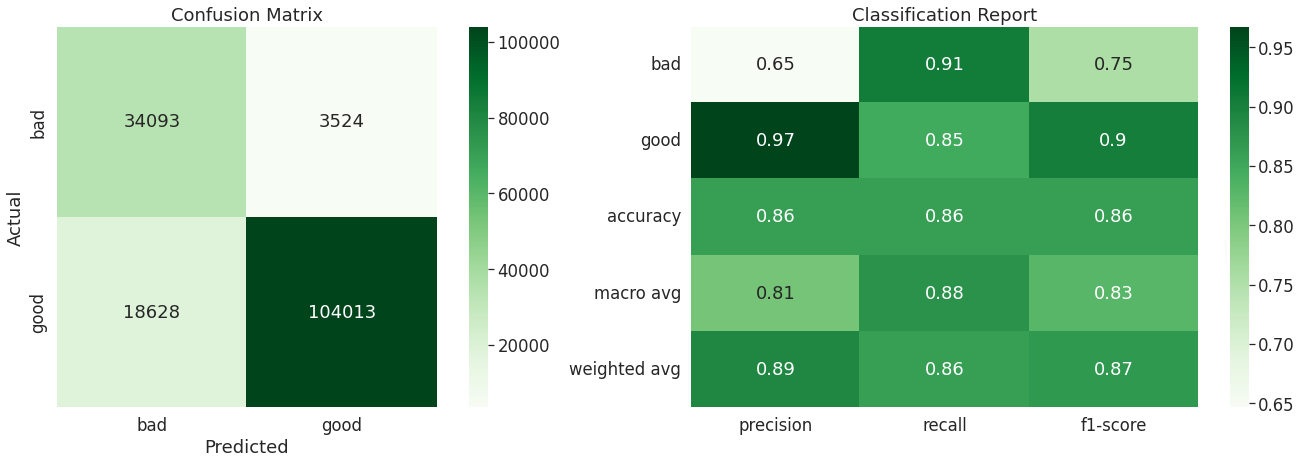

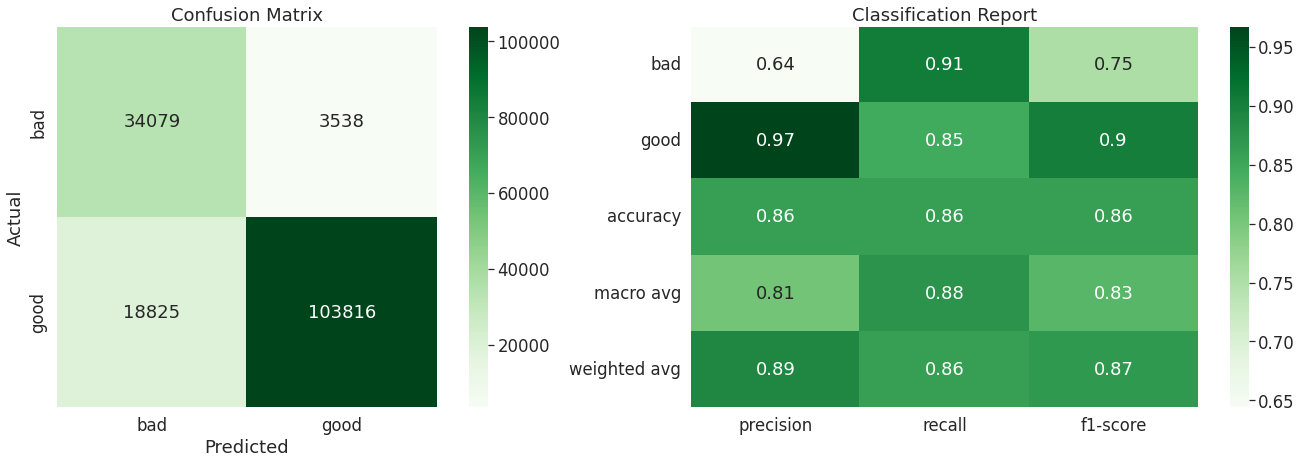

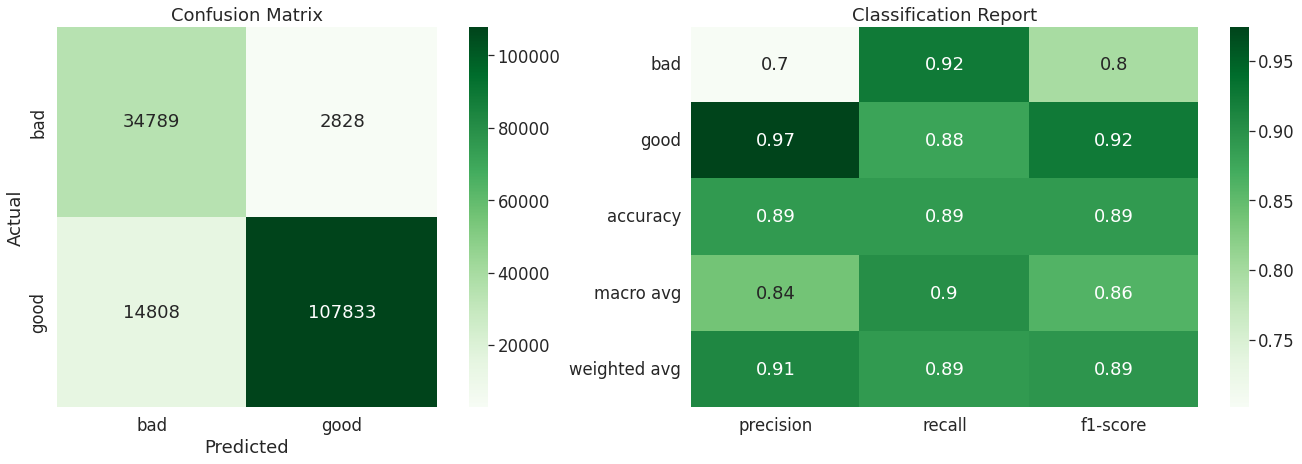

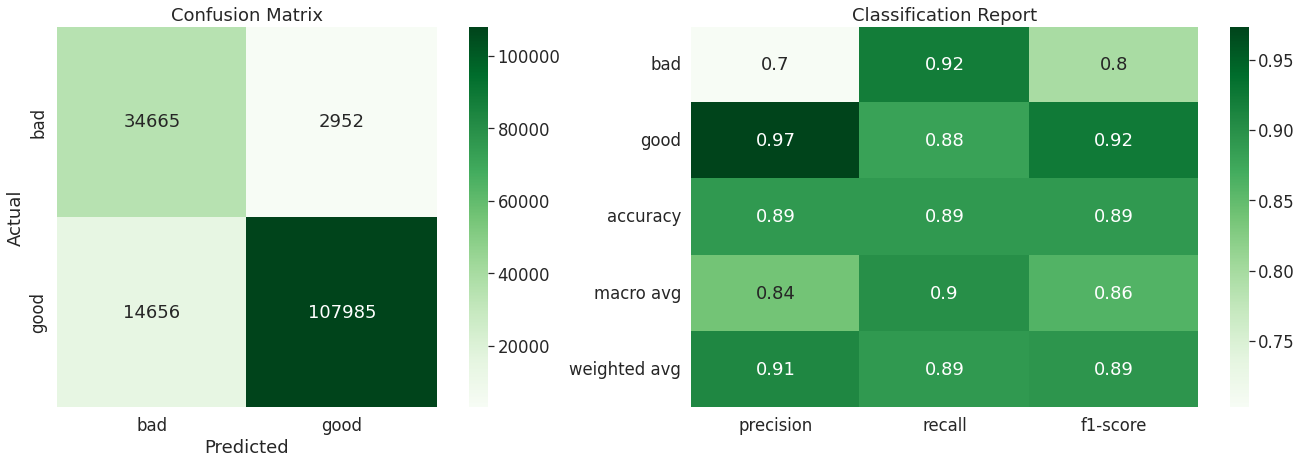

In [ ]:
classifiers = []
classifiers.append(LogisticRegression(random_state=randomstate))
classifiers.append(MultinomialNB())
classifiers.append(pipeline.Pipeline([("nystroem", Nystroem(n_components=1000, random_state=randomstate)),
                                     ("sgdClassifier", SGDClassifier(random_state = randomstate))]))
classifiers.append(SGDClassifier(random_state = randomstate))
classifiers.append(XGBClassifier())
# takes really long to train, so take other parameters although not optimal
classifiers.append(CatBoostClassifier(iterations=150, depth=3, silent=True))

report_flag = False
for i, (train_index, test_index) in enumerate(strat_kfold.split(X_train, y_train)):
  print(f"Fold {i}:")
  print(f"  Trainsamples: {len(train_index)}")
  print(f"  Validationsamples: {len(test_index)}")
  
  # getting datasets with indices
  X_train_fold = X_train.iloc[train_index]
  y_train_fold = y_train.iloc[train_index]

  X_val_fold = X_train.iloc[test_index]
  y_val_fold = y_train.iloc[test_index]
  
  # balance train_set (X and y)
  X_train_balanced, y_train_balanced = balance_data(X_train_fold, y_train_fold)

  # transform feature vector for each fold to prevent data leakage
  count_train, count_val = count_vectorize(X_train_balanced, X_val_fold)
  tfidf_vec_train, tfidf_vec_val, tfidf_combined_train, tfidf_combined_val = tfidf_vectorize(X_train_balanced, X_val_fold)
  embedded_train, embedded_val = use_embedding(X_train_balanced, X_val_fold)

  # concatenate indirect features for embedding
  embedded_combined_train = np.concatenate((embedded_train, X_train_balanced['relative_capitals'].to_numpy()[:, None], X_train_balanced['Review Votes'].to_numpy()[:, None]), axis=1)
  embedded_combined_val = np.concatenate((embedded_val, X_val_fold['relative_capitals'].to_numpy()[:, None], X_val_fold['Review Votes'].to_numpy()[:, None]), axis=1)

  # print classification report for every last fold of classifiers just to see other metrics as well
  if i == strat_kfold.get_n_splits() - 1:
    report_flag = True
    print(f"Last Fold Reports for every classifier, {len(reports[0])} feature "
    "representations each:\n"
    "1. CountVectorizer\n"
    "2. Tf-IdfVectorizer\n"
    "3. Tf-IdfVectorizer + 2 more features\n"
    "4. Universal Sentence Encoder Embedding\n"
    "5. Universal Sentence Encoder Embedding + 2 more features")

  # train each classifier on current fold and save reports
  for j, clf in enumerate(classifiers):
    print(f"Training Fold {i} Classifier {classifier_names[j]}:\n")
    # first count features
    recall, f1 = modeling(clf, count_train, y_train_balanced, 
                          count_val, y_val_fold, report_flag)
    
    reports[j, 0, 0] += recall
    reports[j, 0, 1] += f1

    # then tf-idf with indirect features
    recall, f1 = modeling(clf, tfidf_combined_train, y_train_balanced, 
                          tfidf_combined_val, y_val_fold, report_flag)
    
    reports[j, 1, 0] += recall
    reports[j, 1, 1] += f1

    # then without indrirect
    recall, f1 = modeling(clf, tfidf_vec_train, y_train_balanced, 
                          tfidf_vec_val, y_val_fold, report_flag)
    
    reports[j, 2, 0] += recall
    reports[j, 2, 1] += f1

    
    # then with embedding

    # use GaussianNB for embedding, because there are also negative Values
    if classifier_names[j] == 'Naive Bayes':
      clf = GaussianNB()
    recall, f1 = modeling(clf, embedded_train, y_train_balanced, 
                          embedded_val, y_val_fold, report_flag)
    
    reports[j, 3, 0] += recall
    reports[j, 3, 1] += f1

    recall, f1 = modeling(clf, embedded_combined_train, y_train_balanced, 
                          embedded_combined_val, y_val_fold, report_flag)
    
    reports[j, 4, 0] += recall
    reports[j, 4, 1] += f1
  
# take avg of splits (before just added)
reports /= strat_kfold.get_n_splits()


PLotting results:

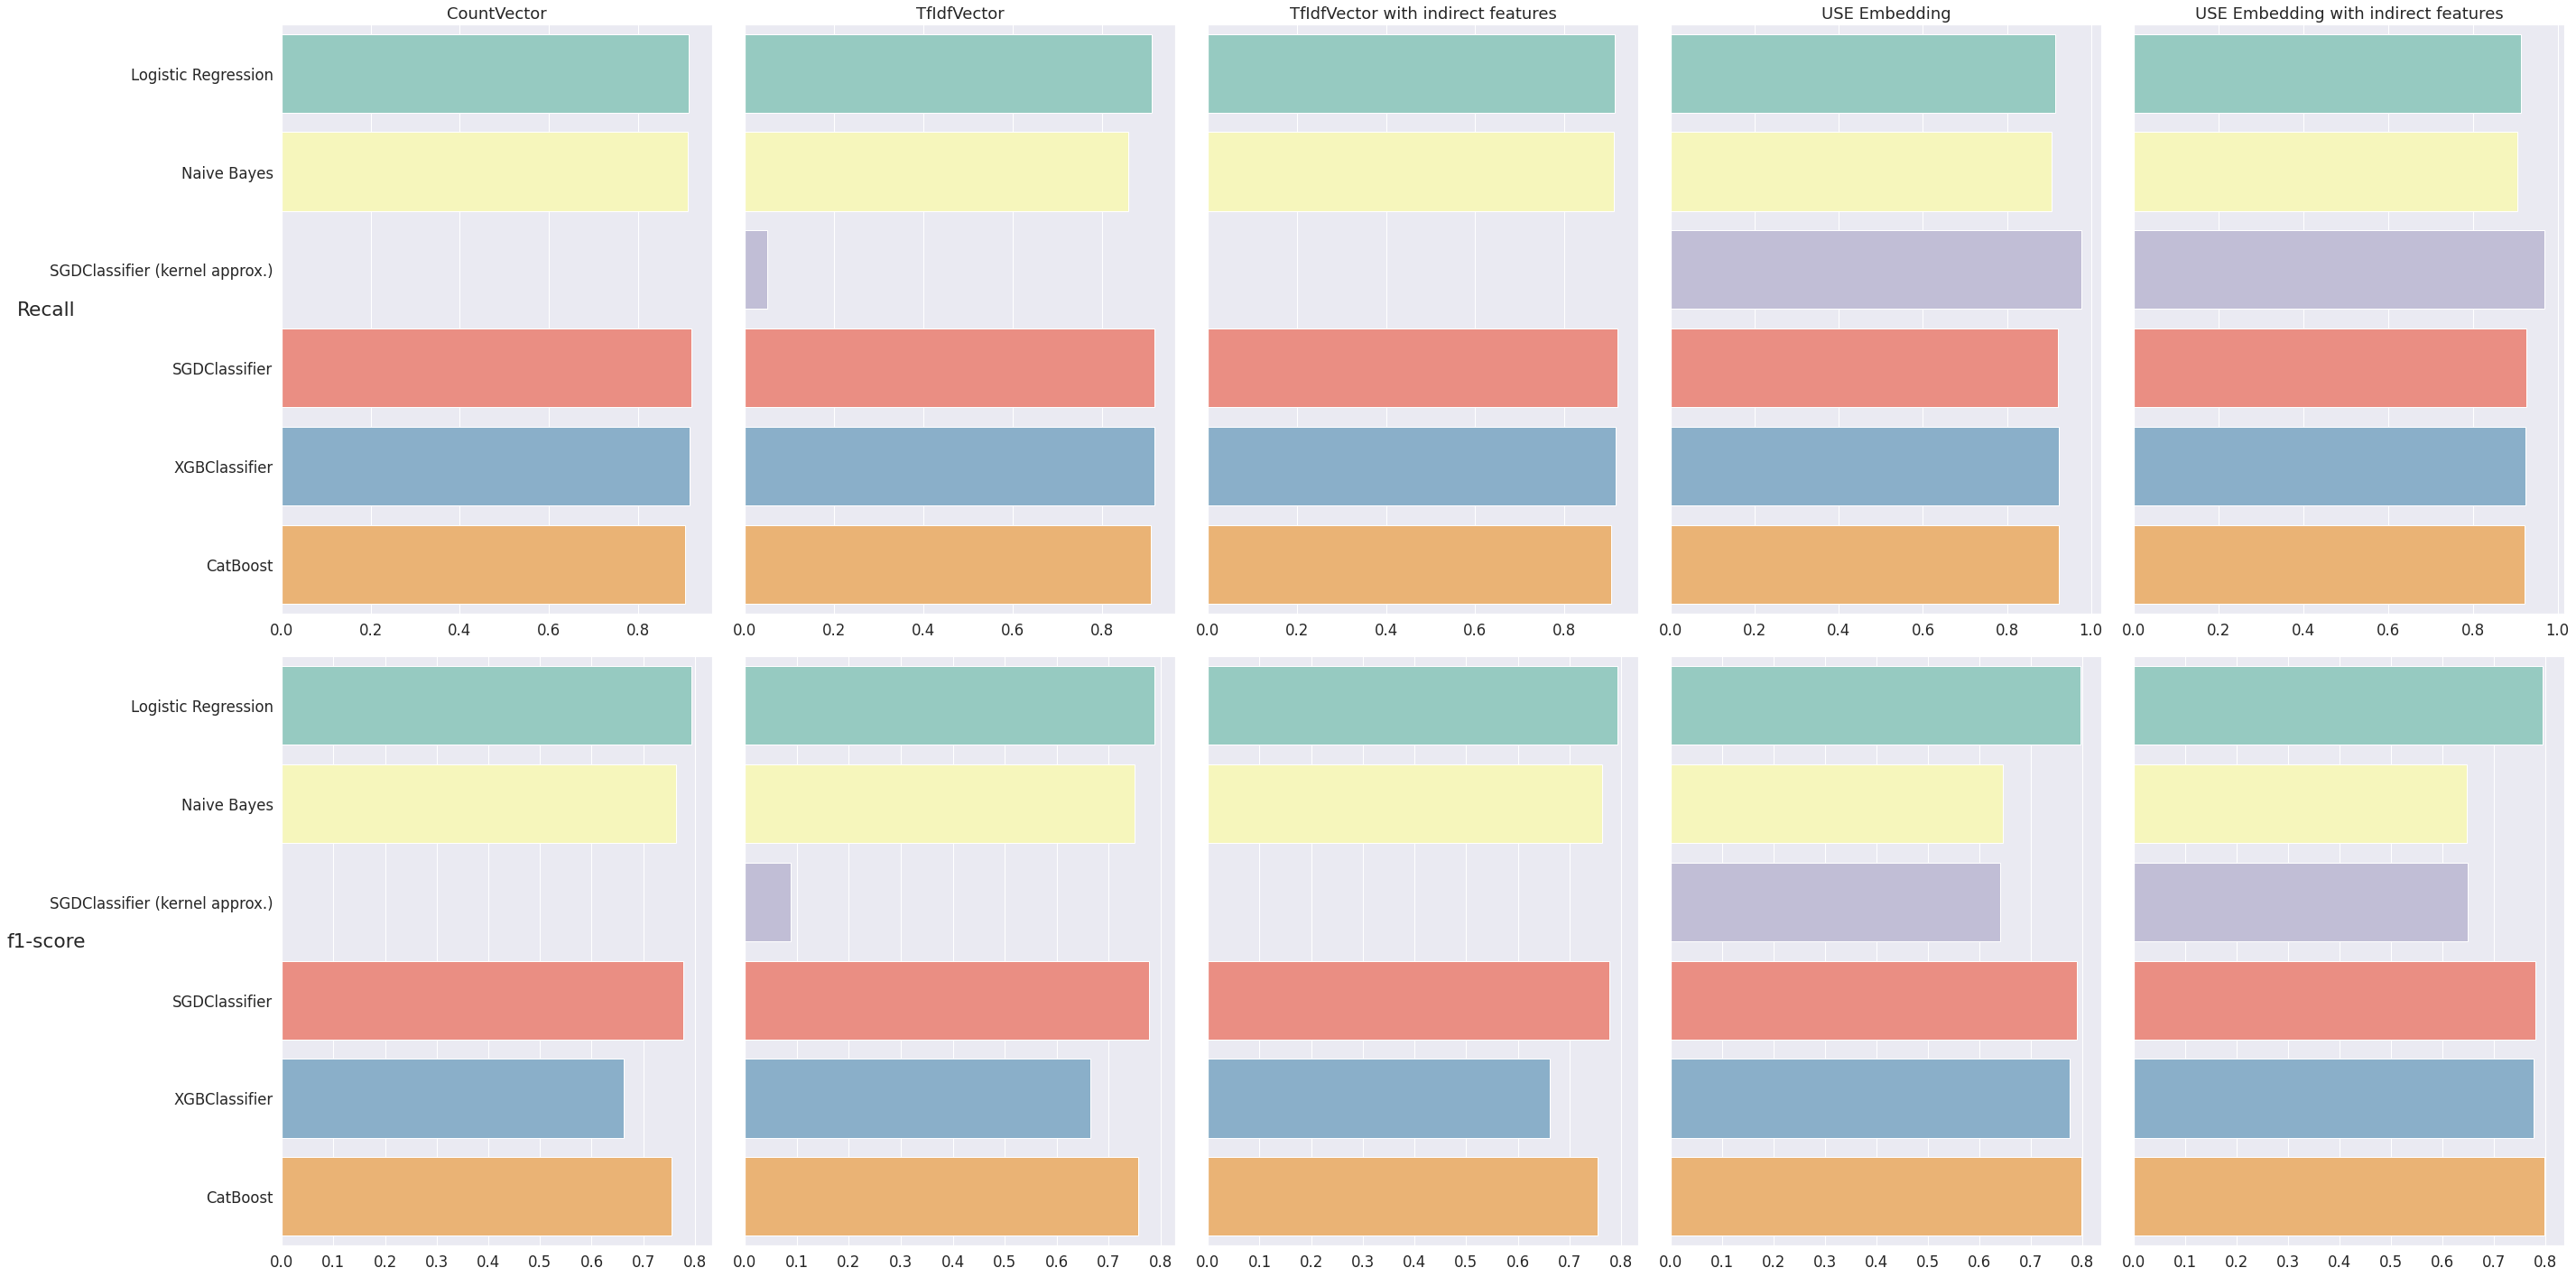

In [ ]:
# putting reports in a dataframe
results = pd.DataFrame({"algorithm":classifier_names, 
                        "count_recall":reports[:, 0, 0], 
                        "tfidf_recall":reports[:, 1, 0],
                        "indirect_tfidf_recall":reports[:, 2, 0],
                        "embedding_recall":reports[:, 3, 0],
                        "indirect_embedding_recall":reports[:, 4, 0],
                        "count_f1":reports[:, 0, 1],
                        "tfidf_f1":reports[:, 1, 1],
                        "indirect_tfidf_f1":reports[:, 2, 1],
                        "embedding_f1":reports[:, 3, 1],
                        "indirect_embedding_f1":reports[:, 4, 1]})
cols = ['CountVector', 'TfIdfVector', 'TfIdfVector with indirect features', 
        'USE Embedding', 'USE Embedding with indirect features']
rows = ['Recall', 'f1-score']

f, ax = plt.subplots(2, 5, figsize=(40, 20))

sns.barplot(data=results, x='count_recall', y='algorithm', ax=ax[0, 0], 
            palette="Set3")
sns.barplot(data=results, x='tfidf_recall', y='algorithm', ax=ax[0, 1], 
            palette="Set3")
sns.barplot(data=results, x='indirect_tfidf_recall', y='algorithm', ax=ax[0, 2], 
            palette="Set3")
sns.barplot(data=results, x='embedding_recall', y='algorithm', ax=ax[0, 3], 
            palette="Set3")
sns.barplot(data=results, x='indirect_embedding_recall', y='algorithm', ax=ax[0, 4], 
            palette="Set3")
sns.barplot(data=results, x='count_f1', y='algorithm', ax=ax[1, 0], 
            palette="Set3")
sns.barplot(data=results, x='tfidf_f1', y='algorithm', ax=ax[1, 1], 
            palette="Set3")
sns.barplot(data=results, x='indirect_tfidf_f1', y='algorithm', ax=ax[1, 2], 
            palette="Set3")
sns.barplot(data=results, x='embedding_f1', y='algorithm', ax=ax[1, 3], 
            palette="Set3")
sns.barplot(data=results, x='indirect_embedding_f1', y='algorithm', ax=ax[1, 4], 
            palette="Set3")

# every column is a feature representation, every row a score
for axis, col in zip(ax[0], cols):
  axis.set_title(col)
for axis, row in zip(ax[:, 0], rows):
  axis.set_ylabel(row, rotation=0, size='large')
counter = 0
for axis_row in ax[:, 1:]:
  for axis in axis_row:
    axis.get_yaxis().set_visible(False)
    axis.set_xlabel("")
ax[0, 0].set_xlabel("")
ax[1, 0].set_xlabel("")
f.tight_layout()
plt.show()

results[['algorithm', 'count_recall', 'tfidf_recall', 'indirect_tfidf_recall', 'embedding_recall', 'indirect_embedding_recall']].style

In [ ]:
results[['algorithm', 'count_f1', 'tfidf_f1', 'indirect_tfidf_f1', 'embedding_f1', 'indirect_embedding_f1']].style

Questions:
- Why does Kernel Approximation not work at all for count vectors?
-> applied it wrong
-> non-linear approximation not suitable for problem
-> sample feature dimensions dont have much to do with word counts anymore
(kernel applied to every sample combination and stored as features)
-> to few datarows sampled for feature map (roughly 1000) and therefore not representative
-> dimension drastically reduced from ~20k to ~1k
-> hyperparameters crucial to be tuned

**Results**:


Overall:
- XGBClassifier performed poorly with count features but good with embeddings
- NaiveBayes good with count and bad with embeddings, but overall worse than others
- SGDClassifier with kernel approximation completely failed with count vectorizations. Embedding got the best result for recall though, with a relatively low f1 score
- linear SGDClassifier, Logistic Regression and CatBoost got an overall good score
- embeddings didnt change much, but all 3 best classifiers performed best with USE embedding
- indirect features didnt change results much

Confusion Matrix + Classification Report:
- all of the three classifiers got an accuracy of 89% and performed pretty good on good reviews
- all tend to predict more bad reviews than good reviews (which is better than the other way) because precision on good reviews is really high (97%) and recall a little lower
- precision of negative class is relatively low for all classifiers 

Classifiers for Hyperparamtertuning:
- SGDClassifier with Embedding
- logistic regression with embedding
- catboost with embedding

### Hyperparameter Tuning for selected sklearn Models

Notes:
- Use GridSearchCV or RandomSearchCV (if to expensive)
- use imbalanced learn package to add a sampler to the pipeline (RandomUnderSampler to compare with results above. Other techniques mostly rely on NearestNeighbor procedures which might not perform well with high dimensional text features)
- also use class_weight = balanced parameter to decide which method against the imbalanced dataset is more effective
- score function should be either f1_macro -> higher penalty for minority class or, a make_scorer function that just takes one class into account
-> as the models still did better on positive reviews, negative recall was great and is most important, but lacked in precision -> optimise f1 score of just the minority class

In [ ]:
# define score metric
f1_neg = make_scorer(f1_score, average='binary', pos_label=0)

# create new splitter for tuning: here 4-fold
strat_kfold = StratifiedKFold(n_splits=4)

# define undersampler
randomstate = 42
sampler = RandomUnderSampler(random_state=randomstate)

# create embedding of data
# can be applied before splitting, because there is no fit
X_train_embedded, _ = use_embedding(X_train)

**Logistic Regression**:

Parameters:
- sampling or class_weights
- Solver: sag (for large datasets with many features), lbfgs(default), liblinear (for large scale, high dimensionality)
- C for regularization

In [ ]:
pipe = Pipeline([('random_sample', sampler), ('logistic_reg', LogisticRegression(random_state=randomstate))])

# use one grid for sampling and one for class_weights
parameter_grid=[{'logistic_reg__solver': ['sag', 'lbfgs', 'liblinear'],
                 'logistic_reg__C': [0.1, 0.5, 1, 10, 50, 100]},
                {'random_sample': ['passthrough'],
                 'logistic_reg__class_weight': ['balanced'],
                 'logistic_reg__solver': ['sag', 'lbfgs', 'liblinear'],
                 'logistic_reg__C': [0.1, 0.5, 1, 10, 50, 100]}
                ]

gs_lr = GridSearchCV(pipe, param_grid=parameter_grid, scoring=f1_neg, 
                     cv=strat_kfold, verbose=2)
gs_lr.fit(X_train_embedded, y_train)

best_lr = gs_lr.best_estimator_
print(f"Best mean f1-score for negative class: {gs_lr.best_score_}")
gs_lr.best_params_

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV] END ......logistic_reg__C=0.1, logistic_reg__solver=sag; total time=  11.5s
[CV] END ......logistic_reg__C=0.1, logistic_reg__solver=sag; total time=  11.4s
[CV] END ......logistic_reg__C=0.1, logistic_reg__solver=sag; total time=  12.1s
[CV] END ......logistic_reg__C=0.1, logistic_reg__solver=sag; total time=  11.4s
[CV] END ....logistic_reg__C=0.1, logistic_reg__solver=lbfgs; total time=   9.2s
[CV] END ....logistic_reg__C=0.1, logistic_reg__solver=lbfgs; total time=   7.0s
[CV] END ....logistic_reg__C=0.1, logistic_reg__solver=lbfgs; total time=   8.1s
[CV] END ....logistic_reg__C=0.1, logistic_reg__solver=lbfgs; total time=   7.8s
[CV] END logistic_reg__C=0.1, logistic_reg__solver=liblinear; total time=  12.1s
[CV] END logistic_reg__C=0.1, logistic_reg__solver=liblinear; total time=  12.2s
[CV] END logistic_reg__C=0.1, logistic_reg__solver=liblinear; total time=  12.1s
[CV] END logistic_reg__C=0.1, logistic_reg__sol

{'logistic_reg__C': 100,
 'logistic_reg__class_weight': 'balanced',
 'logistic_reg__solver': 'sag',
 'random_sample': 'passthrough'}

**Results**
- slight but no significant improvement (~0.3%) in f1_score
- no balancing just weight adjusting
- sag instead of default solver
- highest C was used, so try for slightly higher C if still improves

In [ ]:
pipe = Pipeline([('random_sample', sampler), ('logistic_reg', LogisticRegression(random_state=randomstate))])
parameter_grid={'random_sample': ['passthrough'],
                'logistic_reg__solver':['sag'],
                 'logistic_reg__class_weight': ['balanced'],
                 'logistic_reg__C': [100, 150, 200]}

gs_lr = GridSearchCV(pipe, param_grid=parameter_grid, scoring=f1_neg, 
                     cv=strat_kfold, verbose=2)
gs_lr.fit(X_train_embedded, y_train)

best_lr = gs_lr.best_estimator_
print(f"Best mean f1-score for negative class: {gs_lr.best_score_}")
gs_lr.best_params_

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] END logistic_reg__C=100, logistic_reg__class_weight=balanced, logistic_reg__solver=sag, random_sample=passthrough; total time= 2.8min
[CV] END logistic_reg__C=100, logistic_reg__class_weight=balanced, logistic_reg__solver=sag, random_sample=passthrough; total time= 3.0min
[CV] END logistic_reg__C=100, logistic_reg__class_weight=balanced, logistic_reg__solver=sag, random_sample=passthrough; total time= 2.8min
[CV] END logistic_reg__C=100, logistic_reg__class_weight=balanced, logistic_reg__solver=sag, random_sample=passthrough; total time= 2.8min
[CV] END logistic_reg__C=150, logistic_reg__class_weight=balanced, logistic_reg__solver=sag, random_sample=passthrough; total time= 2.8min
[CV] END logistic_reg__C=150, logistic_reg__class_weight=balanced, logistic_reg__solver=sag, random_sample=passthrough; total time= 3.5min
[CV] END logistic_reg__C=150, logistic_reg__class_weight=balanced, logistic_reg__solver=sag, random_sample

{'logistic_reg__C': 100,
 'logistic_reg__class_weight': 'balanced',
 'logistic_reg__solver': 'sag',
 'random_sample': 'passthrough'}

**SGDClassifier**

Parameter:
- loss: hinge (SVM)
- sampling or class_weights
- learning_rate: optimal(default) or adaptive(learning rate decreases if n_iter_no_change times no better loss (or score, if combined with early_stopping=True))
- alpha: just for 'optimal', used to compute learning_rate: 0.00001, 0.0001(default), 0.001, 0.01, 0.1
- eta0 (initial learning rate, just used for adaptive): 0.0001, 0.001, 0.01, 0.1
- early_stopping: True and False (just for adaptive)
- n_iter_no_change: 3, 5(default), 10
- tol (stopping criteria): 1e-1, 1e-3(default), 1e-5


In [ ]:
pipe = Pipeline([('random_sample', sampler), ('sgd', SGDClassifier(random_state=randomstate))])

# first grid: balanced class weights with 'optimal' leanring_rate
# second grid: balanced class weights with 'adaptive' learning rate
# third/fourth grid: sampling with both learning rate options
parameter_grid=[{'random_sample': ['passthrough'],
                 'sgd__class_weight': ['balanced'],
                 'sgd__alpha': [0.0001, 0.001, 0.01, 0.1],
                 'sgd__n_iter_no_change': [3, 5, 10],
                 'sgd__tol': [1e-1, 1e-3, 1e-5]},
                {'random_sample': ['passthrough'],
                 'sgd__class_weight': ['balanced'],
                 'sgd__learning_rate': ['adaptive'],
                 'sgd__eta0': [0.0001, 0.001, 0.01, 0.1],
                 'sgd__n_iter_no_change': [3, 5, 10],
                 'sgd__tol': [1e-1, 1e-3, 1e-5],
                 'sgd__early_stopping': [True, False]},
                {'sgd__learning_rate': ['adaptive'],
                 'sgd__eta0': [0.0001, 0.001, 0.01, 0.1],
                 'sgd__n_iter_no_change': [3, 5, 10],
                 'sgd__tol': [1e-1, 1e-3, 1e-5],
                 'sgd__early_stopping': [True, False]},
                {'sgd__alpha': [0.0001, 0.001, 0.01, 0.1],
                 'sgd__n_iter_no_change': [3, 5, 10],
                 'sgd__tol': [1e-1, 1e-3, 1e-5]}]

gs_sgd = GridSearchCV(pipe, param_grid=parameter_grid, scoring=f1_neg, 
                     cv=strat_kfold, verbose=2)
gs_sgd.fit(X_train_embedded, y_train)

best_sgd = gs_sgd.best_estimator_
print(f"Best mean f1-score for negative class: {gs_sgd.best_score_}")
gs_sgd.best_params_

Fitting 4 folds for each of 216 candidates, totalling 864 fits
[CV] END random_sample=passthrough, sgd__alpha=0.0001, sgd__class_weight=balanced, sgd__n_iter_no_change=3, sgd__tol=0.1; total time=   3.5s
[CV] END random_sample=passthrough, sgd__alpha=0.0001, sgd__class_weight=balanced, sgd__n_iter_no_change=3, sgd__tol=0.1; total time=   2.2s
[CV] END random_sample=passthrough, sgd__alpha=0.0001, sgd__class_weight=balanced, sgd__n_iter_no_change=3, sgd__tol=0.1; total time=   2.2s
[CV] END random_sample=passthrough, sgd__alpha=0.0001, sgd__class_weight=balanced, sgd__n_iter_no_change=3, sgd__tol=0.1; total time=   2.2s
[CV] END random_sample=passthrough, sgd__alpha=0.0001, sgd__class_weight=balanced, sgd__n_iter_no_change=3, sgd__tol=0.001; total time=   3.2s
[CV] END random_sample=passthrough, sgd__alpha=0.0001, sgd__class_weight=balanced, sgd__n_iter_no_change=3, sgd__tol=0.001; total time=   3.7s
[CV] END random_sample=passthrough, sgd__alpha=0.0001, sgd__class_weight=balanced, sgd_

{'sgd__alpha': 0.0001, 'sgd__n_iter_no_change': 5, 'sgd__tol': 0.1}

**Results**:

- slight improvement (~1%)
- most parameter as default
- tol parameter at upper bound, so try a few higher ones

In [ ]:
pipe = Pipeline([('random_sample', sampler), ('sgd', SGDClassifier(random_state=randomstate))])
parameter_grid={
                 'sgd__tol': [0.05, 0.1, 0.2, 0.4]}

gs_sgd = GridSearchCV(pipe, param_grid=parameter_grid, scoring=f1_neg, 
                     cv=strat_kfold, verbose=2)
gs_sgd.fit(X_train_embedded, y_train)

best_sgd = gs_lr.best_estimator_
print(f"Best mean f1-score for negative class: {gs_sgd.best_score_}")
gs_sgd.best_params_

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END ......................................sgd__tol=0.05; total time=   2.4s
[CV] END ......................................sgd__tol=0.05; total time=   2.2s
[CV] END ......................................sgd__tol=0.05; total time=   2.3s
[CV] END ......................................sgd__tol=0.05; total time=   2.6s
[CV] END .......................................sgd__tol=0.1; total time=   2.3s
[CV] END .......................................sgd__tol=0.1; total time=   2.0s
[CV] END .......................................sgd__tol=0.1; total time=   1.8s
[CV] END .......................................sgd__tol=0.1; total time=   2.0s
[CV] END .......................................sgd__tol=0.2; total time=   1.8s
[CV] END .......................................sgd__tol=0.2; total time=   1.8s
[CV] END .......................................sgd__tol=0.2; total time=   1.9s
[CV] END .......................................s

{'sgd__tol': 0.05}

**CatBoost**:

Parameter:
- sampling or auto_class_weights='Balanced'
- Iterations: 50, 150, 300
- Learning Rate: 0.001, 0.01, 0.1, auto
- depth: 1, 3, 5
- early_stopping_rounds (number of iterations since best metric): False, 5, 10 

In [ ]:
# create new splitter for tuning: here 3-fold
strat_kfold = StratifiedKFold(n_splits=3)
pipe = Pipeline([('random_sample', sampler), ('cat_boost', CatBoostClassifier(silent=True))])

# first grid: balanced class weights with costum learning rates
# second grid: balanced class weights with auto learning rate
# third/fourth grid: sampling with both learning rate options 
parameter_distribution =[{'random_sample': ['passthrough'],
                 'cat_boost__auto_class_weights': ['Balanced'],
                 'cat_boost__learning_rate': [0.001, 0.01, 0.1],
                 'cat_boost__iterations': [50, 150, 300],
                 'cat_boost__depth': [1, 3, 5],
                 'cat_boost__early_stopping_rounds': [False, 5, 10]},
                {'random_sample': ['passthrough'],
                 'cat_boost__auto_class_weights': ['Balanced'],
                 'cat_boost__iterations': [50, 150, 300],
                 'cat_boost__depth': [1, 3, 5],
                 'cat_boost__early_stopping_rounds': [False, 5, 10]},
                {'cat_boost__learning_rate': [0.001, 0.01, 0.1],
                 'cat_boost__iterations': [50, 150, 300],
                 'cat_boost__depth': [1, 3, 5],
                 'cat_boost__early_stopping_rounds': [False, 5, 10]},
                {'cat_boost__iterations': [50, 150, 300],
                 'cat_boost__depth': [1, 3, 5],
                 'cat_boost__early_stopping_rounds': [False, 5, 10]}]

# random search, because cat boost would take to long
rs_cb = RandomizedSearchCV(pipe, n_iter=65, param_distributions=parameter_distribution, scoring=f1_neg, 
                     cv=strat_kfold, verbose=2)
rs_cb.fit(X_train_embedded, y_train)

best_cb = rs_cb.best_estimator_
print(f"Best mean f1-score for negative class: {rs_cb.best_score_}")
rs_cb.best_params_

Fitting 3 folds for each of 65 candidates, totalling 195 fits
[CV] END cat_boost__depth=5, cat_boost__early_stopping_rounds=False, cat_boost__iterations=300, cat_boost__learning_rate=0.1; total time=   3.9s
[CV] END cat_boost__depth=5, cat_boost__early_stopping_rounds=False, cat_boost__iterations=300, cat_boost__learning_rate=0.1; total time=   2.3s
[CV] END cat_boost__depth=5, cat_boost__early_stopping_rounds=False, cat_boost__iterations=300, cat_boost__learning_rate=0.1; total time=   2.2s
[CV] END cat_boost__auto_class_weights=Balanced, cat_boost__depth=1, cat_boost__early_stopping_rounds=10, cat_boost__iterations=50, cat_boost__learning_rate=0.1, random_sample=passthrough; total time=  26.5s
[CV] END cat_boost__auto_class_weights=Balanced, cat_boost__depth=1, cat_boost__early_stopping_rounds=10, cat_boost__iterations=50, cat_boost__learning_rate=0.1, random_sample=passthrough; total time=  29.6s
[CV] END cat_boost__auto_class_weights=Balanced, cat_boost__depth=1, cat_boost__early_s

{'cat_boost__iterations': 150,
 'cat_boost__early_stopping_rounds': 5,
 'cat_boost__depth': 5}

**Results**:

- f1-score of negative class increased by more than 2%
- balanced train dataset used

-> as sgdClassifier and CatBoost prefer balanced Dataset, try LogisticRegression with best parameters on balanced Dataset and see if performance decreases (later all models could be used in a VotingClassifier)

In [ ]:
pipe = Pipeline([('random_sample', sampler), ('logistic_reg', LogisticRegression(random_state=randomstate))])
# provide some varation to adapt to now balanced data
parameter_grid={'logistic_reg__solver':['sag', 'lbfgs'],
                 'logistic_reg__C': [50, 100, 150]}

gs_lr = GridSearchCV(pipe, param_grid=parameter_grid, scoring=f1_neg, 
                     cv=strat_kfold, verbose=2)
gs_lr.fit(X_train_embedded, y_train)

best_lr = gs_lr.best_estimator_
print(f"Best mean f1-score for negative class: {gs_lr.best_score_}")
gs_lr.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .......logistic_reg__C=50, logistic_reg__solver=sag; total time= 1.2min
[CV] END .......logistic_reg__C=50, logistic_reg__solver=sag; total time= 1.1min
[CV] END .......logistic_reg__C=50, logistic_reg__solver=sag; total time= 1.1min
[CV] END .....logistic_reg__C=50, logistic_reg__solver=lbfgs; total time=  12.6s
[CV] END .....logistic_reg__C=50, logistic_reg__solver=lbfgs; total time=  13.3s
[CV] END .....logistic_reg__C=50, logistic_reg__solver=lbfgs; total time=  11.7s
[CV] END ......logistic_reg__C=100, logistic_reg__solver=sag; total time= 1.2min
[CV] END ......logistic_reg__C=100, logistic_reg__solver=sag; total time= 1.1min
[CV] END ......logistic_reg__C=100, logistic_reg__solver=sag; total time= 1.1min
[CV] END ....logistic_reg__C=100, logistic_reg__solver=lbfgs; total time=  11.4s
[CV] END ....logistic_reg__C=100, logistic_reg__solver=lbfgs; total time=  12.2s
[CV] END ....logistic_reg__C=100, logistic_reg__s

{'logistic_reg__C': 100, 'logistic_reg__solver': 'sag'}

as the performance decrease is only ~0.15% we take the balanced dataset approach for all models

**Overall Results**:

- Logistic Regression: balance data, solver=sag, C=100
- SGDClassifier: balance data, tol=0.05
- CatBoostClassifier: balance data, iterations=150, depth=5, early_stopping_rounds=5

Also CatBoostClassifier was the best out of all models with a f1-score for the negative class of ~82%

### Neural architectures
- simple LSTM based model (once with custom word embedding and once with use review level embedding)
- simple Transformer based Model (with one encoder alyer or multiple)

In [ ]:
# hyperparameters for both models
vocab_size = 15000
max_len = 100
embed_dim = 300
num_heads = 5
dense_dim = 128
num_encoder_layers = 4
drop_rate = 0.1 # for transformers

precision_neg = keras.metrics.Precision(class_id=0, name='precision_neg')
recall_neg = keras.metrics.Recall(class_id=0, name='recall_neg')
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    mode='min')

In [ ]:
# get data splits

y = data['target'].map({'good':1, 'bad':0})
# '.' must be sperate by spaces to get a seperate token
X = data['clean_sentences'].apply(lambda x: " . ".join(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# split for validation set
X_train_split, X_valid_global, y_train_split, y_valid_global = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# split again to obtain validation set for early stopping and test performance afterwards
X_valid_split, X_test_split, y_valid_split, y_test_split = train_test_split(X_valid_global, y_valid_global, test_size=0.5, random_state=42, stratify=y_valid_global)

# since we want to use sklearn models with balanced data, also try balanced data here
X_train_split, y_train_split = balance_data(X_train_split, y_train_split)

# convert to categorical targets (needed to monitor negative f1-score)
y_train_split = keras.utils.to_categorical(y_train_split)
y_valid_split = keras.utils.to_categorical(y_valid_split)


In [ ]:
# get all data transformations for feature representation


# token indices for custom embedding

# function for converting text into indices for Embedding layer
def get_sequences(tokenizer, text_data, max_len):
  # convert to word index form
  sequences = tokenizer.texts_to_sequences(text_data)
  # pad to get equal shape
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
  return padded


# tokenizer (default filter without '.' to seperate sentences)
tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(X_train_split)

X_train_seq = get_sequences(tokenizer, X_train_split, max_len)
X_val_seq = get_sequences(tokenizer, X_valid_split, max_len)
X_test_seq = get_sequences(tokenizer, X_test_split, max_len)


# use embedding
X_train_embed, _ = use_embedding(X_train_split)
X_valid_embed, _ = use_embedding(X_valid_split)
X_test_embed, _ = use_embedding(X_test_split)

# reshape inputs, because 3d expected (sequence length more than 1)
X_train_embed = X_train_embed.reshape(-1, 1, 512)
X_valid_embed = X_valid_embed.reshape(-1, 1, 512)
X_test_embed = X_test_embed.reshape(-1, 1, 512)


#### LSTM Based Models
- first with custom embedding layer (word embeddings with limited max word number)
- then with USE Embeddings, but just one embedding for the whole review

In [ ]:
# custom embedding

def build_lstm_model(vocab_size, max_len, embed_dim):
  # build model
  seq_lstm = Sequential()
  seq_lstm.add(Embedding(vocab_size, embed_dim, input_length=max_len, mask_zero=True))
  seq_lstm.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
  seq_lstm.add(Bidirectional(LSTM(128, dropout=0.2)))
  seq_lstm.add(Dense(64, activation='relu'))
  seq_lstm.add(Dropout(0.2))
  # output layer
  seq_lstm.add(Dense(2, activation='softmax'))

  # compile model

  seq_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[precision_neg, recall_neg])
  seq_lstm.summary()
  return seq_lstm

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          4500000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                

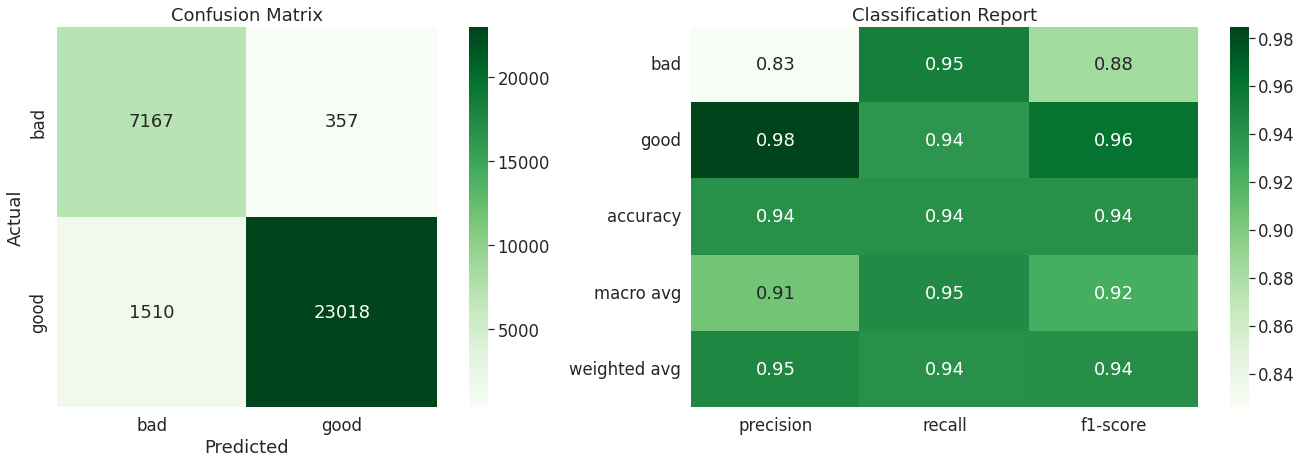

In [ ]:
seq_lstm = build_lstm_model(vocab_size, max_len, embed_dim)


# fit model (just train ones and go from there because of costs)

# save the model with best precision_neg score and compare with other model
save_best = keras.callbacks.ModelCheckpoint("lstm_model.h5", 
                                            monitor='val_precision_neg', mode='max',
                                            save_best_only=True)


seq_lstm.fit(X_train_seq, y_train_split,
            batch_size=64, epochs=30, 
             validation_data=(X_val_seq, y_valid_split),
             callbacks=[early_stopping, save_best])

y_pred = seq_lstm.predict(X_test_seq)

# categorical output, so take class with highest probability
y_pred = np.argmax(y_pred, axis=1)
f1_neg = f1_score(y_test_split, y_pred, average='binary', pos_label=0)
print(f1_neg)
plot_reports(y_test_split, y_pred)


1002/1002 [==============================] - 18s 13ms/step
0.8860775427995972


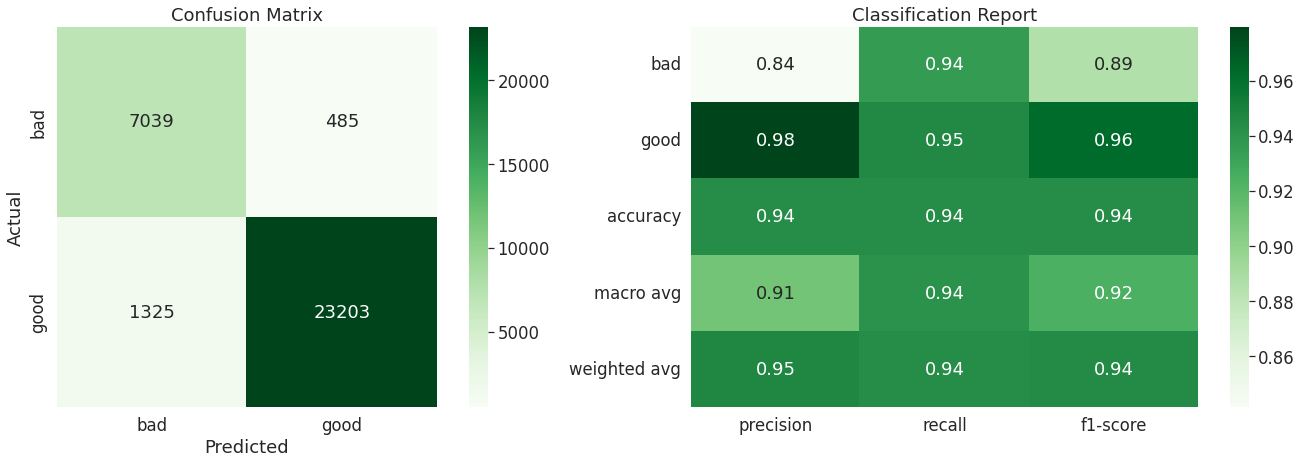

In [ ]:
# load best model that was saved
lstm_model = keras.models.load_model(
    "lstm_model.h5")

y_pred = lstm_model.predict(X_test_seq)

# categorical output, so take class with highest probability
y_pred = np.argmax(y_pred, axis=1)
f1_neg = f1_score(y_test_split, y_pred, average='binary', pos_label=0)
print(f1_neg)
plot_reports(y_test_split, y_pred)

In [ ]:
import json
lstm_model.save("./drive/MyDrive/lstm_model.h5")
tokenizer_json = tokenizer.to_json()
with open('./drive/MyDrive/tokenizer.json', 'w') as f:
  f.write(json.dumps(tokenizer_json))

2505/2505 [==============================] - 36s 14ms/step
0.8799299299299299


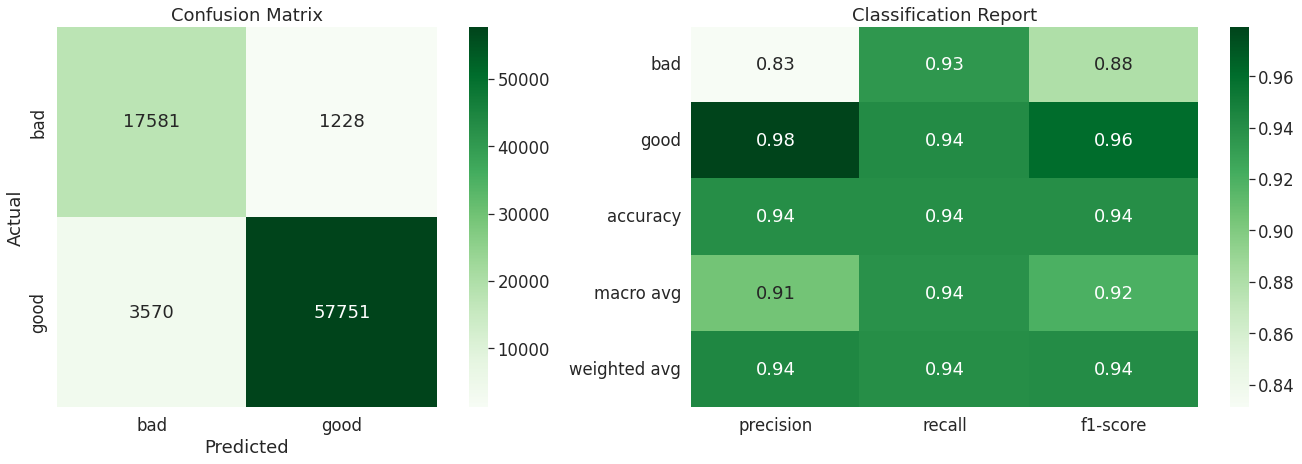

In [ ]:
X_test_global = get_sequences(tokenizer, X_test, max_len)

y_pred_global = lstm_model.predict(X_test_global)

# categorical output, so take class with highest probability
y_pred_global = np.argmax(y_pred_global, axis=1)
f1_neg = f1_score(y_test, y_pred_global, average='binary', pos_label=0)
print(f1_neg)
plot_reports(y_test, y_pred_global)

**Results**:

- first run already outperformed all ML models

- after second run (different parameters and early_stopping): all performances increased, f1-score for negative class almost 90%
- might be a little higher if best model during training is saved

In [ ]:
# now with USE embedding, first define model

# almost the same, but inputs are just the 512dimensional vectors per review
def build_use_model():
  input_shape = (1, 512)

  # build model
  seq_lstm = Sequential()
  seq_lstm.add(keras.Input(shape=input_shape))
  seq_lstm.add(Bidirectional(LSTM(units=64, input_shape=input_shape, return_sequences=True)))
  seq_lstm.add(Bidirectional(LSTM(units=64)))
  seq_lstm.add(Dense(32, activation='relu'))
  seq_lstm.add(Dropout(0.3))
  # output layer
  seq_lstm.add(Dense(2, activation='softmax'))

  # compile model

  seq_lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[precision_neg, recall_neg])
  seq_lstm.summary()
  return seq_lstm

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_20 (Bidirecti  (None, 1, 128)           295424    
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_96 (Dense)            (None, 32)                4128      
                                                                 
 dropout_57 (Dropout)        (None, 32)                0         
                                                                 
 dense_97 (Dense)            (None, 2)                 66        
                                                                 
Total params: 398,434
Trainable params: 398,434
Non-t

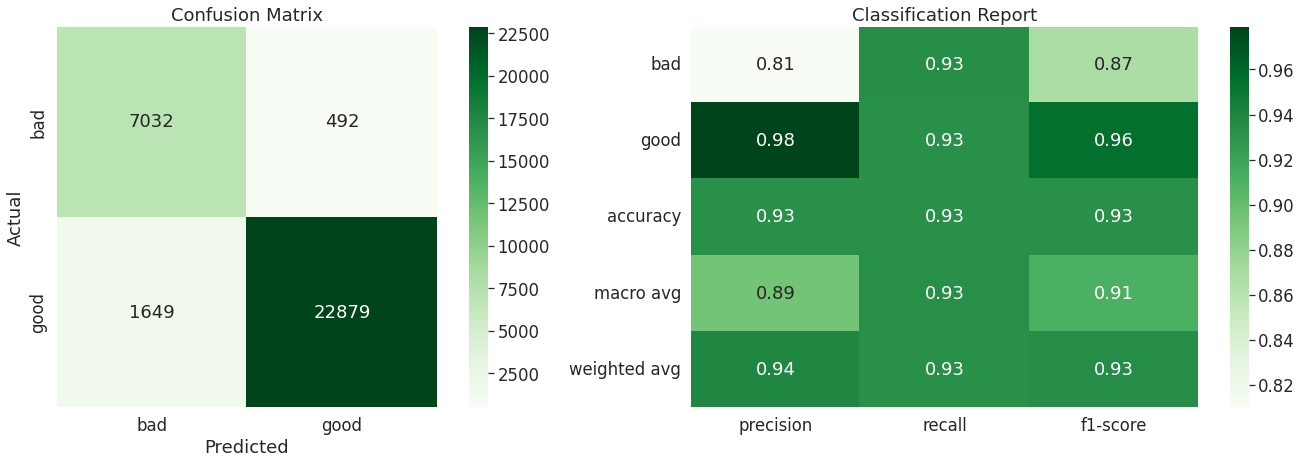

In [ ]:
# build model
use_model = build_use_model()


# fit model (just train ones and go from there because of costs)

use_model.fit(X_train_embed, y_train_split,
            batch_size=64, epochs=30, 
             validation_data=(X_valid_embed, y_valid_split),
             callbacks=[early_stopping])

y_pred = use_model.predict(X_test_embed)

# categorical output, so take class with highest probability
y_pred = np.argmax(y_pred, axis=1)
f1_neg = f1_score(y_test_split, y_pred, average='binary', pos_label=0)
print(f1_neg)
plot_reports(y_test_split, y_pred)

**Results**:

- USE Embedding still outperforms sklearn models
- performance much lower than custom embeddings with same model
- training is significantly faster though, since Model has more than 10x less trainable parameters

#### Transformer model
- define TransformerEncoder for classification (no decoder needed)
- define an positional encoding layer
- combine to a model

##### 1. Costum Transformer

In [ ]:
# defining the layer classes

# almost similar to attention is all you need encoder
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, drop_rate=drop_rate, **kwargs):
    super().__init__(**kwargs)
    # variable that tells keras to pass mask on to other layers (costum layers dont by default)
    self.supports_masking = True

    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.drop_rate = drop_rate
    self.attention = layers.MultiHeadAttention(num_heads=num_heads, 
                                               key_dim=embed_dim)
    # positionwise feed-forward, last dense layer has to have embedding_dim as output
    self.dense_seq = Sequential(
        [Dense(dense_dim, activation='relu'), 
         Dense(embed_dim, activation='relu'),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout = Dropout(drop_rate)
  
  def call(self, inputs, training, mask=None):
    # if masked 0 entries in sequence -> apply newaxis, cause attention mask needs
    # to be 3D
    if mask is not None:
      # broadcast to required shape: (batch, heads, query, key) (2D before)
      mask = mask[:, tf.newaxis, :]

    # apply self-attention
    attention_output = self.attention(inputs, inputs, attention_mask=mask)
    dense_input = self.layernorm1(inputs + attention_output)
    # feed to sequential layers afterwards
    dense_output = self.dense_seq(dense_input)
    dense_output = self.dropout(dense_output, training=training)
    return self.layernorm2(dense_input + dense_output)
  
  # needed for saving the model
  def get_config(self):
    config = super().get_config()
    config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
        "drop_rate": self.drop_rate,
    })
    return config

class PositionalEmbedding(layers.Layer):
  def __init__(self, max_len, vocab_size, embed_dim, **kwargs):
    super().__init__(**kwargs)
    # first embed sequences the normal way with tokens
    self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
    # then apply positions
    self.position_emb = Embedding(input_dim=max_len, output_dim=embed_dim)
    self.max_len = max_len
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
  
  def call(self, inputs):
    # gets current seq_len (always self.max_len if padded uniformly)
    seq_len = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=seq_len, delta=1)
    # first use normal word embedding
    embed_tokens = self.token_emb(inputs)
    # then apply embedding for each position index
    embed_pos = self.position_emb(positions)
    # combine
    return embed_tokens + embed_pos
  
  # pass mask to next layers 
  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

   # needed for saving the model
  def get_config(self):
    config = super().get_config()
    config.update({
        "max_len": self.max_len,
        "vocab_size": self.vocab_size,
        "embed_dim": self.embed_dim,
    })
    return config


def build_transformer(vocab_size, max_len, embed_dim, num_heads, dense_dim,
                      num_encode_layers=1, use_embed=False):
 
  # skip embedding if use is used
  if not use_embed:
    inputs = keras.Input(shape=(max_len, ), dtype="int64")
    x = PositionalEmbedding(max_len, vocab_size, embed_dim)(inputs)

    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
  else:
    inputs = keras.Input(shape=(max_len, embed_dim), dtype="float32")
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(inputs)

  # skip first encoder layer
  for i in range(num_encode_layers - 1):
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
  # convert to compatible input for dense
  x = layers.GlobalMaxPooling1D()(x)
  x = Dropout(drop_rate)(x)
  x = Dense(dense_dim, activation='relu')(x)
  x = Dropout(drop_rate)(x)
  outputs = Dense(2, activation='softmax')(x)

  model = keras.Model(inputs, outputs)

  # compile model

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[precision_neg, recall_neg])
  model.summary()
  return model


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 positional_embedding (Posit  (None, 100, 300)         4530000   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  (None, 100, 300)         1883228   
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                             

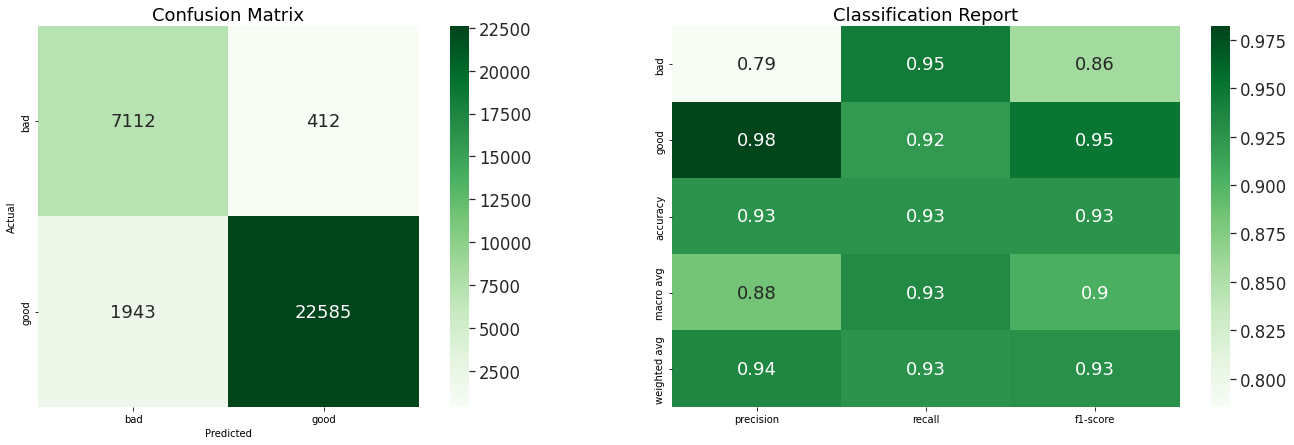

In [ ]:

transformer_model = build_transformer(vocab_size, max_len, embed_dim, 
                                      num_heads, dense_dim)


transformer_model.fit(X_train_seq, y_train_split,
            batch_size=64, epochs=20, 
             validation_data=(X_val_seq, y_valid_split),
             callbacks=[early_stopping])
y_pred = transformer_model.predict(X_test_seq)

# categorical output, so take class with highest probability
y_pred = np.argmax(y_pred, axis=1)
f1_neg = f1_score(y_test_split, y_pred, average='binary', pos_label=0)
print(f1_neg)
plot_reports(y_test_split, y_pred)

2. Multiple TransformerEncoder layers
- one with positional encoding layer
- one with use embedding (review level)

In [ ]:
# with custom embedding

transformer_model = build_transformer(vocab_size, max_len, embed_dim, 
                                      num_heads, dense_dim, num_encoder_layers)


transformer_model.fit(X_train_seq, y_train_split,
            batch_size=64, epochs=4, 
             validation_data=(X_val_seq, y_valid_split),
             callbacks=[early_stopping])
y_pred = transformer_model.predict(X_test_seq)

# categorical output, so take class with highest probability
y_pred = np.argmax(y_pred, axis=1)
f1_neg = f1_score(y_test_split, y_pred, average='binary', pos_label=0)
print(f1_neg)
plot_reports(y_test_split, y_pred)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 positional_embedding_4 (Pos  (None, 100, 300)         4530000   
 itionalEmbedding)                                               
                                                                 
 transformer_encoder_17 (Tra  (None, 100, 300)         1883228   
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_18 (Tra  (None, 100, 300)         1883228   
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_19 (Tra  (None, 100, 300)         1883228   
 nsformerEncoder)                                          

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 512)]          0         
                                                                 
 transformer_encoder_1 (Tran  (None, 1, 512)           5384832   
 sformerEncoder)                                                 
                                                                 
 transformer_encoder_2 (Tran  (None, 1, 512)           5384832   
 sformerEncoder)                                                 
                                                                 
 transformer_encoder_3 (Tran  (None, 1, 512)           5384832   
 sformerEncoder)                                                 
                                                                 
 transformer_encoder_4 (Tran  (None, 1, 512)           5384832   
 sformerEncoder)                                           

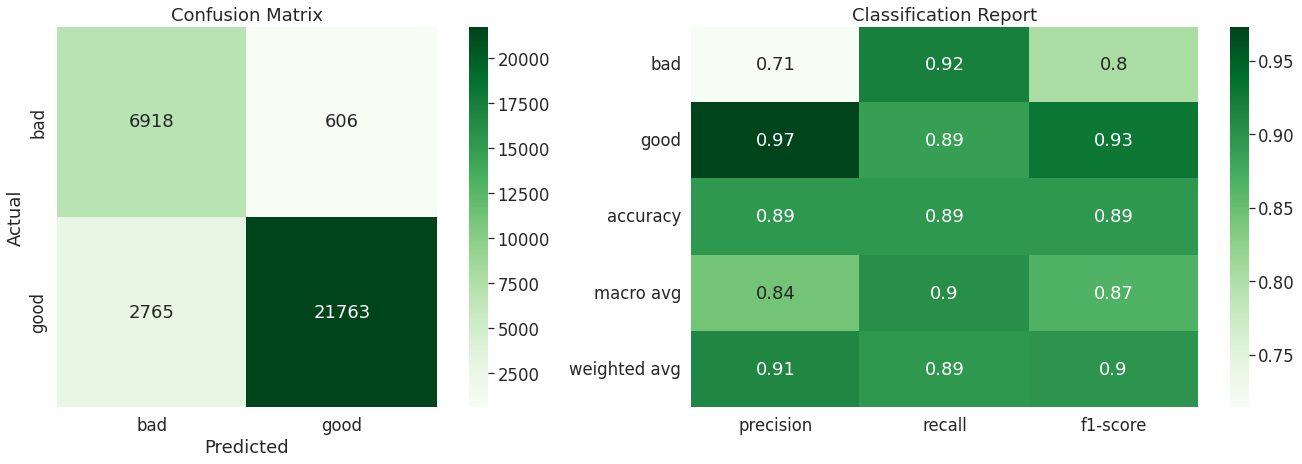

In [ ]:
# with use embedding

transformer_model = build_transformer(vocab_size, 1, 512, 
                                      num_heads, dense_dim, num_encoder_layers,
                                      use_embed=True)


transformer_model.fit(X_train_embed, y_train_split,
            batch_size=64, epochs=15, 
             validation_data=(X_valid_embed, y_valid_split),
             callbacks=[early_stopping])
y_pred = transformer_model.predict(X_test_embed)

# categorical output, so take class with highest probability
y_pred = np.argmax(y_pred, axis=1)
f1_neg = f1_score(y_test_split, y_pred, average='binary', pos_label=0)
print(f1_neg)
plot_reports(y_test_split, y_pred)

**Results**:

- Different Transformer Architectures dont perform as well as simple LSTM Network
- Even more complex Transformer (multiple Encoder Layers) perform significantly worse

-> Implementation wrong? Masking not passed correctly? (but use doesnt use a mask and still worse)

-> since LSTM performed significantly better than sklearn models, no voting but just this model for inference

(came across relatively new KerasNLP API with built-in TransformerEncoder Layers and whole pretrained models like BERT, but didnt include it in this work)